In [1]:
import os
import re
import sys

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.display import display

from copy import deepcopy
import logging as log

import pickle
import xlrd
import xlwt
import pylab

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Directory with IGU datasets:
ROOT_DIR = "RawData"

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('odym', 'modules')
DataPath = os.path.join('docs', 'files')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))
sys.path.insert(0, os.path.join(os.getcwd(), 'docs', 'files'))

# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\02_MFA_IGU\outputs\IMG


In [4]:
import ODYM_Classes as msc  # import the ODYM class file
import ODYM_Functions as msf  # import the ODYM function file
import dynamic_stock_model as dsm  # import the dynamic stock model library

In [5]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)

In [6]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [7]:
pd.set_option('precision', 2)

In [8]:
# A custom formatter function which divide by 1000 an axis:
import matplotlib.ticker as tkr


def yfmt1000(x, pos):
    s = f'{x/1000:,.0f}'
    return s

# W/ classes for tick-locating and -formatting:


# A formatter function:
y_1000 = tkr.FuncFormatter(yfmt1000)

# To divide the y-axis by 1000 when needed:
# ax.yaxis.set_major_formatter(y_1000)

In [9]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [10]:
# A keyword to export figures, or not:
export = False

# Upload Datasets

In [11]:
# Belgian dataset:
be_data = input_helper.get_data(
    'BE_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

# French dataset:
fr_data = input_helper.get_data(
    'FR_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

# European dataset:
eu_data = input_helper.get_data(
    'eu_igu_RawData_VPython.xlsx', directory=ROOT_DIR)

In [12]:
print("be_data, sheet names = \n {}\n".format(be_data.sheet_names))
print("fr_data, sheet names = \n {}\n".format(fr_data.sheet_names))
print("eu_data, sheet names = \n {}\n".format(eu_data.sheet_names))

be_data, sheet names = 
 ['References', 'consumption', 'prod', 'import', 'export', 'thickness', 'Energy_Intensity', 'Population']

fr_data, sheet names = 
 ['References', 'consumption', 'prod', 'import', 'export', 'Population', 'thickness', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

eu_data, sheet names = 
 ['References', 'stock', 'prod', 'import', 'export', 'thickness', 'emissions', 'Energy_Intensity']



# Material, Energy and Carbon Intensity in the Flat Glass Industry

See: Souviron J and A Z Khan. (Forthcoming). "The Materiality of Transparency: An Environmental Analysis of the Architectural Flat Glass Industry since 1945 in Europe, France and Belgium". _Resources, Conservation and Recycling_.

## Material intensity since 1945, France

In [13]:
# Creating a DataFrame for material intensity:
df_rawmat = fr_data.parse('RawMat_Intensity').set_index('year')

In [14]:
df_rawmat['cullet, kg/kg'] = (df_rawmat['internal cullet, kg/kg']
                              + df_rawmat['external cullet, kg/kg'])

In [15]:
materials = ['sand', 'cullet', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

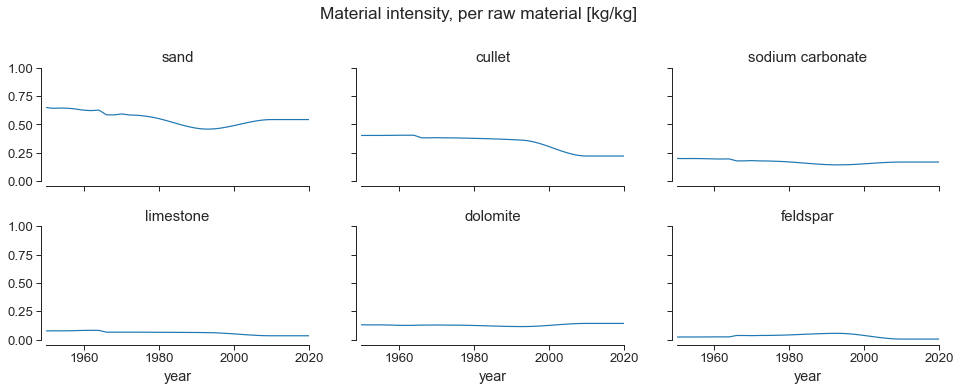

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (df_rawmat[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax)
     )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material [kg/kg]", y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

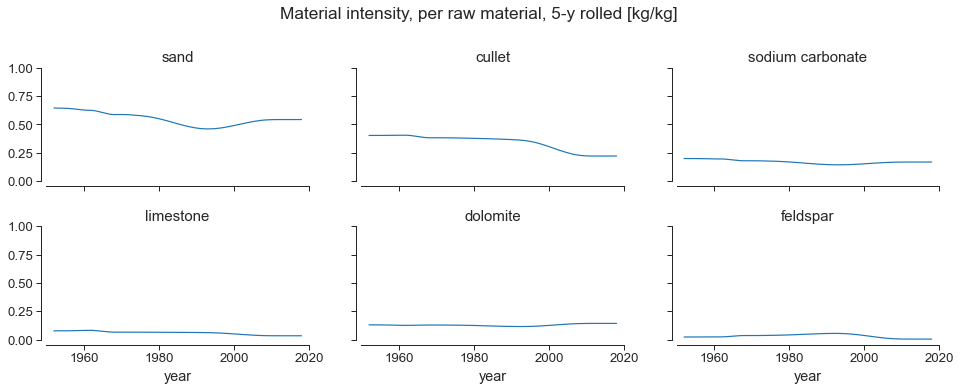

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (df_rawmat[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material, 5-y rolled [kg/kg]",
             y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

In [18]:
# Estimate the material intensity (sum of the intenisities per material):
df_rawmat['Total raw materials, kg/kg'] = 0

for mat in materials:
    df_rawmat['Total raw materials, kg/kg'] = (
        df_rawmat[f"{mat}, kg/kg"]
        + df_rawmat['Total raw materials, kg/kg']
    )

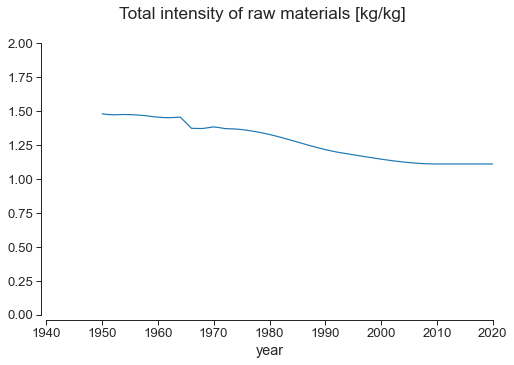

In [19]:
# Plot the material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_rawmat,
             x=df_rawmat.index,
             y=(df_rawmat['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials [kg/kg]")

sns.despine(offset=5)
plt.show()

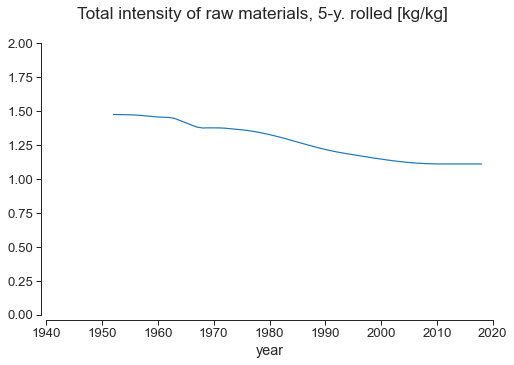

In [20]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_rawmat,
             x=df_rawmat.index,
             y=(df_rawmat['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

In [21]:
matwocullet = ['sand', 'sodium carbonate', 'limestone',
               'dolomite', 'feldspar']

In [22]:
# Estimate the material intensity without cullet:
df_rawmat['Total raw mat w/o cullet, kg/kg'] = 0

for mat in matwocullet:
    df_rawmat['Total raw mat w/o cullet, kg/kg'] = (
        df_rawmat[f"{mat}, kg/kg"]
        + df_rawmat['Total raw mat w/o cullet, kg/kg']
    )

In [23]:
# Alternatively:
df_rawmat['Total raw mat w/o cullet, kg/kg'] = df_rawmat[[
    f"{mat}, kg/kg" for mat in matwocullet]].dropna(how='any', axis=0).sum(axis=1)

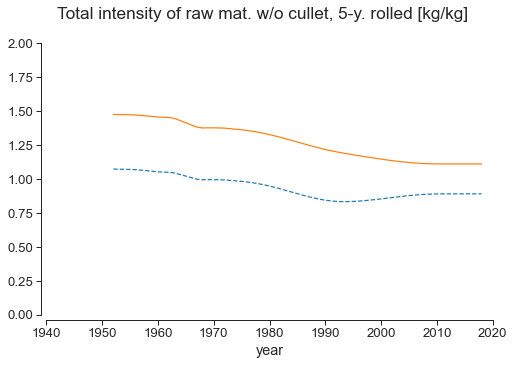

In [24]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_rawmat,
             x=df_rawmat.index,
             y=(df_rawmat['Total raw mat w/o cullet, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax, linestyle='--')

sns.lineplot(data=df_rawmat,
             x=df_rawmat.index,
             y=(df_rawmat['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw mat. w/o cullet, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

## Energy Intensity since 1945, France and Belgium

In [25]:
# Create a DataFrame for the energy intensity in France:
df_fr_energy = fr_data.parse('Energy_Intensity').set_index('year')

df_be_energy = be_data.parse('Energy_Intensity').set_index('year')

In [26]:
# Create a unique DataFrame for FR and BE flat glass flows:
df_be_fr_energy = pd.concat(
    [df_fr_energy['fuel oil, GJ/t'],
     df_be_energy['fuel oil, GJ/t'],
     df_fr_energy['natural gas, GJ/t'],
     df_be_energy['natural gas, GJ/t'],
     df_fr_energy['electricity, GJ/t'],
     df_be_energy['electricity, GJ/t']],
    axis=1, keys=[('fuel oil, GJ/t', 'France'),
                  ('fuel oil, GJ/t', 'Belgium'),
                  ('natural gas, GJ/t', 'France'),
                  ('natural gas, GJ/t', 'Belgium'),
                  ('electricity, GJ/t', 'France'),
                  ('electricity, GJ/t', 'Belgium')],
    names=['Info', 'Country']
).stack(dropna=False)

df_be_fr_energy = df_be_fr_energy.unstack()

In [27]:
energies = ['fuel oil', 'natural gas', 'electricity']

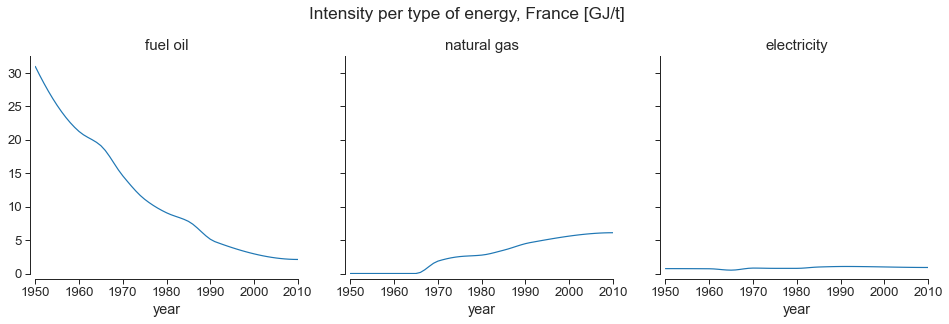

In [28]:
# Plot the intensity per type of energy, France:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (df_be_fr_energy[(f"{energy}, GJ/t", "France")]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Intensity per type of energy, France [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

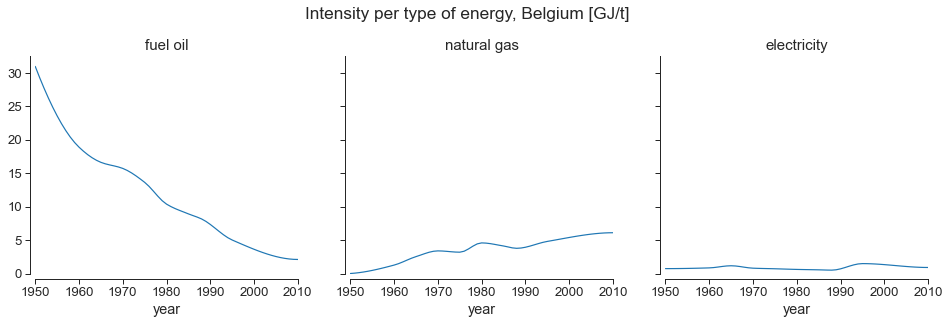

In [29]:
# Plot the intensity per type of energy, Belgium:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (df_be_fr_energy[(f"{energy}, GJ/t", "Belgium")]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Intensity per type of energy, Belgium [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

In [30]:
countries = ['Belgium', 'France']

In [31]:
# Estimate the total energy intensity
# (sum of the intensities per type of energy):
for country in countries:
    df_be_fr_energy[('Total energy, GJ/t', country)] = 0
    for energy in energies:
        df_be_fr_energy[('Total energy, GJ/t', country)] = (
            df_be_fr_energy[('Total energy, GJ/t', country)]
            + df_be_fr_energy[(f"{energy}, GJ/t", country)]
        )

In [32]:
fossilfuels = ['fuel oil', 'natural gas']

In [33]:
# Estimate the total energy intensity
# (without electricity)
for country in countries:
    df_be_fr_energy[('Total energy w/o elec., GJ/t', country)] = 0
    for energy in fossilfuels:
        df_be_fr_energy[('Total energy w/o elec., GJ/t', country)] = (
            df_be_fr_energy[(
                'Total energy w/o elec., GJ/t', country)]
            + df_be_fr_energy[(f"{energy}, GJ/t", country)]
        )

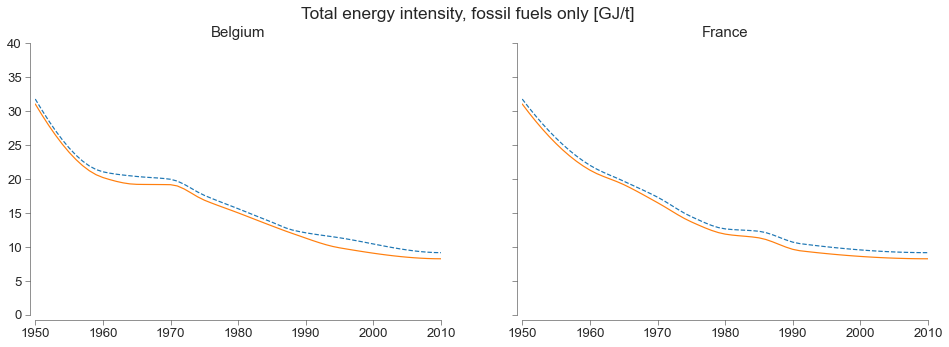

In [34]:
# Plot the total energy intensity:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    sns.lineplot(data=df_be_fr_energy,
                 x=df_be_fr_energy.index,
                 y=(df_be_fr_energy[('Total energy, GJ/t', country)]
                    .interpolate(method='pchip', limit_direction='forward')),
                 ax=ax, linestyle='--')

    sns.lineplot(data=df_be_fr_energy,
                 x=df_be_fr_energy.index,
                 y=(df_be_fr_energy[('Total energy w/o elec., GJ/t',
                                     country)]
                    .interpolate(method='pchip', limit_direction='forward')),
                 ax=ax)

    ax.set_xlim(1950, 2010)
    ax.set_ylim(0, 40)
    ax.set_title(country)
    ax.yaxis.label.set_visible(False)
    style_ax(ax)


fig.suptitle("Total energy intensity, fossil fuels only [GJ/t]")

sns.despine(offset=5)
plt.show()

In [35]:
# Estimate energy intensity according to ratios:
for energy in energies:
    for country in countries:
        df_be_fr_energy[(f"{energy}, %", country)] = (
            (df_be_fr_energy[(f"{energy}, GJ/t", country)]
             .interpolate(method='pchip', limit_direction='forward'))
            / (df_be_fr_energy[('Total energy, GJ/t', country)]
               .interpolate(method='pchip', limit_direction='forward'))
        )

In [36]:
df_be_fr_energy

Info    electricity, GJ/t        fuel oil, GJ/t        natural gas, GJ/t  \
Country           Belgium France        Belgium France           Belgium   
year                                                                       
1945                  NaN    NaN            NaN    NaN               NaN   
1946                  NaN    NaN            NaN    NaN               NaN   
1947                  NaN    NaN            NaN    NaN               NaN   
1948                  NaN    NaN            NaN    NaN               NaN   
1949                  NaN    NaN            NaN    NaN               NaN   
...                   ...    ...            ...    ...               ...   
2016                  NaN    NaN            NaN    NaN               NaN   
2017                  NaN    NaN            NaN    NaN               NaN   
2018                  NaN    NaN            NaN    NaN               NaN   
2019                  0.9    0.9            2.1    2.1               6.1   
2020                  NaN    NaN            NaN    NaN               NaN   

Info           Total energy, GJ/t        Total energy w/o elec., GJ/t         \
Country France            Belgium France                      Belgium France   
year                                                                           
1945       NaN                NaN    NaN                          NaN    NaN   
1946       NaN                NaN    NaN                          NaN    NaN   
1947       NaN                NaN    NaN                          NaN    NaN   
1948       NaN                NaN    NaN                          NaN    NaN   
1949       NaN                NaN    NaN                          NaN    NaN   
...        ...                ...    ...                          ...    ...   
2016       NaN                NaN    NaN                          NaN    NaN   
2017       NaN                NaN    NaN                          NaN    NaN   
2018       NaN                NaN    NaN                          NaN    NaN   
2019       6.1                9.1    9.1                          8.2    8.2   
2020       NaN                NaN    NaN                          NaN    NaN   

Info    fuel oil, %        natural gas, %        electricity, %         
Country     Belgium France        Belgium France        Belgium France  
year                                                                    
1945            NaN    NaN            NaN    NaN            NaN    NaN  
1946            NaN    NaN            NaN    NaN            NaN    NaN  
1947            NaN    NaN            NaN    NaN            NaN    NaN  
1948            NaN    NaN            NaN    NaN            NaN    NaN  
1949            NaN    NaN            NaN    NaN            NaN    NaN  
...             ...    ...            ...    ...            ...    ...  
2016           0.23   0.23           0.67   0.67            0.1    0.1  
2017           0.23   0.23           0.67   0.67            0.1    0.1  
2018           0.23   0.23           0.67   0.67            0.1    0.1  
2019           0.23   0.23           0.67   0.67            0.1    0.1  
2020           0.23   0.23           0.67   0.67            0.1    0.1  

[76 rows x 16 columns]

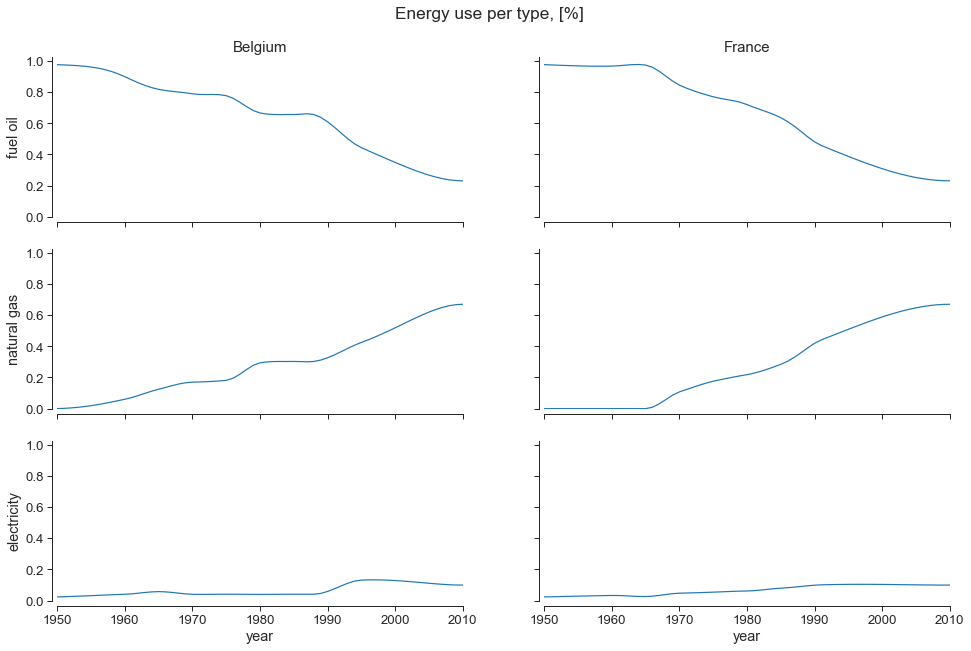

In [37]:
# Plot energy intensity per type of energy and in percent:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        df_be_fr_energy[(f"{energy}, %", country)].plot(ax=ax)

        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Energy use per type, [%]", y=0.95)

sns.despine(offset=5)
plt.show()

## Energy Intensity in the EU since 1970

In [38]:
# Create a DataFrame for the energy intensity in the EU:
df_eu_energy = eu_data.parse('Energy_Intensity').set_index('year')

In [39]:
energies = ['fuel oil', 'natural gas', 'electricity']

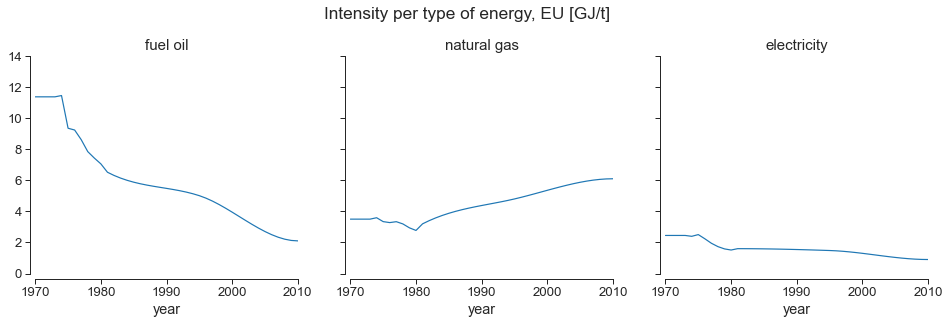

In [40]:
# Plot the intensity per type of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (df_eu_energy[f"{energy}, GJ/t"]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1970, 2010)
ax.set_ylim(0, 14)

fig.suptitle("Intensity per type of energy, EU [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

In [41]:
# Estimate the total energy intensity
# (sum of the intensities per type of energy)
# In Europe:
df_eu_energy['Total energy, GJ/t'] = 0

for energy in energies:
    df_eu_energy['Total energy, GJ/t'] = (
        df_eu_energy['Total energy, GJ/t']
        + df_eu_energy[f"{energy}, GJ/t"]
    )

In [42]:
fossilfuels = ['fuel oil', 'natural gas']

In [43]:
# Estimate the total energy intensity
# (without electricity)
df_eu_energy['Total energy w/o elec., GJ/t'] = 0

for energy in fossilfuels:
    df_eu_energy['Total energy w/o elec., GJ/t'] = (
        df_eu_energy['Total energy w/o elec., GJ/t']
        + df_eu_energy[f"{energy}, GJ/t"]
    )

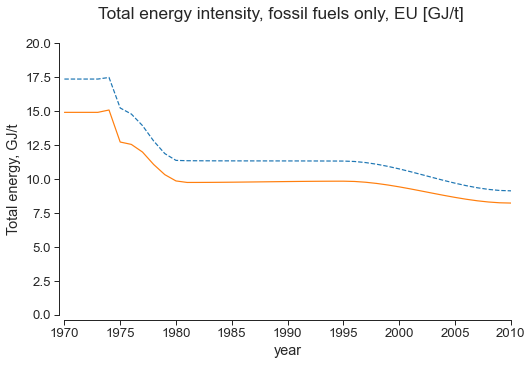

In [44]:
# Plot the total energy intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu_energy,
             x=df_eu_energy.index,
             y=(df_eu_energy['Total energy, GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax, linestyle='--')

sns.lineplot(data=df_eu_energy,
             x=df_eu_energy.index,
             y=(df_eu_energy['Total energy w/o elec., GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.set_xlim(1970, 2010)
ax.set_ylim(0, 20)

fig.suptitle("Total energy intensity, fossil fuels only, EU [GJ/t]")

sns.despine(offset=5)  # , left=True, bottom=True)
plt.show()

In [45]:
# Estimate energy intensity according to ratios:
for energy in energies:
    df_eu_energy[f"{energy}, %"] = (
        (df_eu_energy[(f"{energy}, GJ/t")]
         .interpolate(method='pchip', limit_direction='forward'))
        / (df_eu_energy['Total energy, GJ/t']
           .interpolate(method='pchip', limit_direction='forward'))
    )

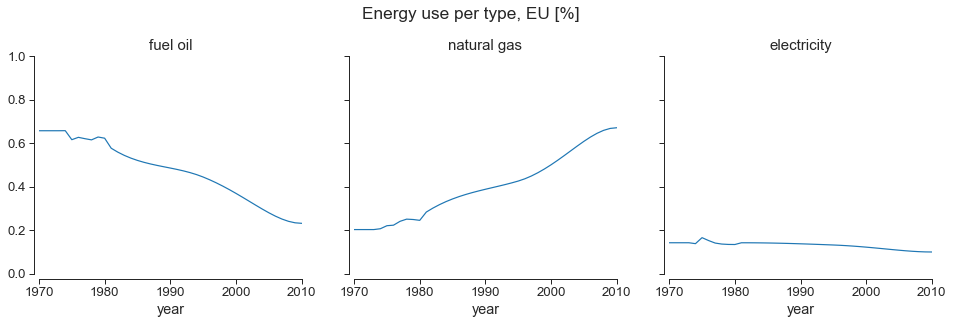

In [46]:
# Plot energy intensity per type of energy and in percent:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    df_eu_energy[f"{energy}, %"].plot(ax=ax)

ax.set_xlim(1970, 2010)
ax.set_ylim(0, 1)

fig.suptitle("Energy use per type, EU [%]", y=1.05)

sns.despine(offset=5)
plt.show()

## Carbon Intensity of the Flat Glass Manufacturing Process in France

In [47]:
# Create a DataFrame only with the CO2 emission data:
fr_emissions = fr_data.parse('emissions').set_index('year')

fr_co2_intensity = fr_emissions[['CO2 glass ind, kg/t']].copy()
fr_co2_intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                        inplace=True)

fr_co2_intensity.dropna()

,CO2 [kg/t]
year,
1947,2970.0
1950,2950.0
1960,2055.0
1965,1815.0
1970,1595.0
1975,1280.0
1980,1070.0
1985,950.0
1990,820.0


In [48]:
# Interpolate CO2 intensity accoring to a pchip method:
fr_co2_intensity['CO2 interpolated [kg/t]'] = (
    fr_co2_intensity['CO2 [kg/t]'].interpolate('pchip')
)

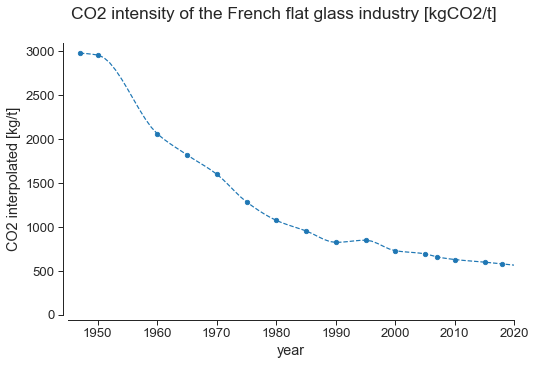

In [49]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=fr_co2_intensity['CO2 interpolated [kg/t]'])

ax.lines[0].set_linestyle("--")

ax.scatter(x=fr_co2_intensity.index, y=fr_co2_intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("CO2 intensity of the French flat glass industry [kgCO2/t]")
sns.despine(offset=5)
plt.show()

## Carbon Intensity of the Flat Glass Manufacturing Process in the EU

In [50]:
# Create a DataFrame only with the CO2 emission data:
df_eu_emissions = eu_data.parse('emissions').set_index('year')

df_eu_co2 = df_eu_emissions[['CO2 glass ind, kg/t']].copy()
df_eu_co2.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                 inplace=True)

df_eu_co2.dropna()

,CO2 [kg/t]
year,
1970,1605.74
1975,1364.88
1980,1204.38
1985,1083.90
1990,1043.78
1991,1012.47
1992,986.35
1993,960.22
1994,929.03


In [51]:
# Interpolate CO2 intensity accoring to a pchip method:
df_eu_co2['CO2 interpolated [kg/t]'] = (
    df_eu_co2['CO2 [kg/t]'].interpolate('pchip')
)

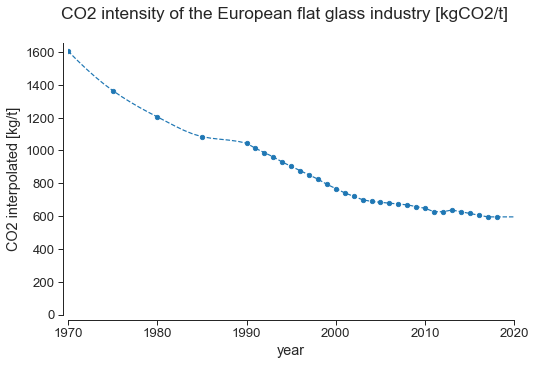

In [52]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu_co2['CO2 interpolated [kg/t]'])

ax.lines[0].set_linestyle("--")

ax.scatter(x=df_eu_co2.index, y=df_eu_co2['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1970, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("CO2 intensity of the European flat glass industry [kgCO2/t]")
sns.despine(offset=5)
plt.show()

## Summary

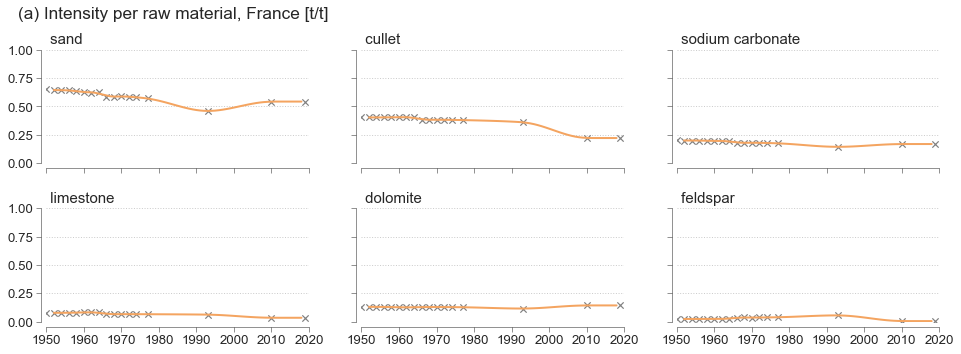

In [53]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (df_rawmat[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown', linewidth=2))

    ax.scatter(x=df_rawmat.index, y=df_rawmat[f"{mat}, kg/kg"],
               s=40, marker='x', c='grey')
    plt.xticks(np.arange(1950, 2021, 10), rotation=45)

    ax.set_title(f" {mat}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle(
    "(a) Intensity per raw material, France [t/t]", x=0.1, y=1, ha='left')

fig.subplots_adjust(wspace=0.2, hspace=0.4)

sns.despine(offset=5)

plt.show()

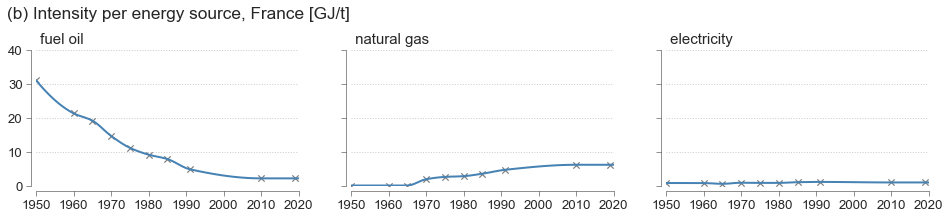

In [54]:
# Plot the energy intensity per source of energy, France:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    (df_be_fr_energy[(f"{energy}, GJ/t", "France")]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=df_be_fr_energy.index,
               y=df_be_fr_energy[(f"{energy}, GJ/t", "France")],
               s=40, marker='x', c='grey')

    ax.set_title(f" {energy}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("(b) Intensity per energy source, France [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

plt.show()

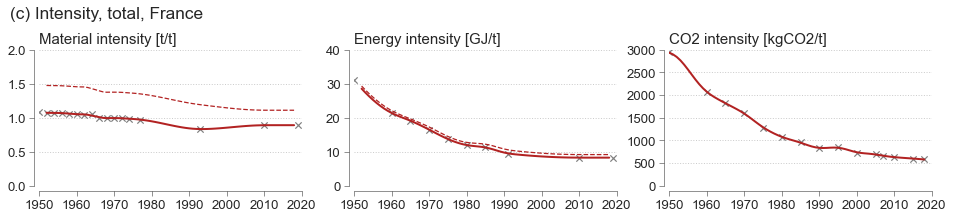

In [55]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(df_rawmat['Total raw materials, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25)
 )

(df_rawmat['Total raw mat w/o cullet, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='-', linewidth=2)
 )

ax.scatter(x=df_rawmat.index,
           y=df_rawmat['Total raw mat w/o cullet, kg/kg'],
           s=40, marker='x', c='grey')

ax.set_title("Material intensity [t/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(df_be_fr_energy[('Total energy, GJ/t', 'France')]
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(df_be_fr_energy[('Total energy w/o elec., GJ/t', 'France')]
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=df_be_fr_energy.index,
           y=df_be_fr_energy[(
               'Total energy w/o elec., GJ/t', 'France')],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(fr_co2_intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=fr_co2_intensity.index, y=fr_co2_intensity['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 3000)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))
plt.yticks(np.arange(0, 3001, 500))

fig.suptitle("(c) Intensity, total, France", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

plt.show()

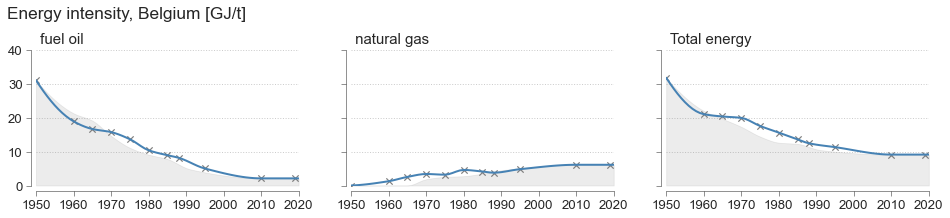

In [56]:
toplot = ['fuel oil', 'natural gas', 'Total energy']

# Plot the energy intensity for Belgium:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, plot) in enumerate(zip(axes.flatten(), toplot)):
    (df_be_fr_energy[(f"{plot}, GJ/t", "Belgium")]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=df_be_fr_energy.index,
               y=df_be_fr_energy[(f"{plot}, GJ/t", "Belgium")],
               s=40, marker='x', c='grey')

    x = (df_be_fr_energy.reset_index()['year'])
    y = (df_be_fr_energy[(f"{plot}, GJ/t", "France")]
         .interpolate(method='pchip', limit_direction='forward'))
    ax.fill_between(x, y, color="grey", alpha=0.15)

    ax.set_title(f" {plot}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("Energy intensity, Belgium [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

plt.show()

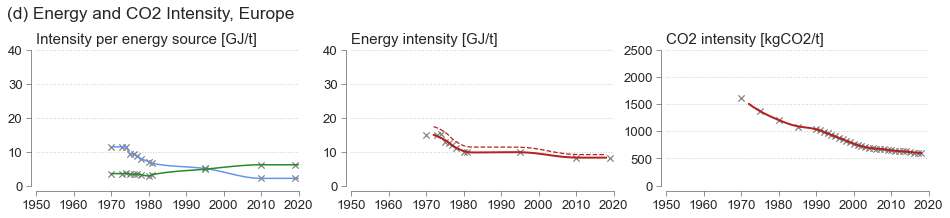

In [57]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Intensity, per energy source
ax = axes[0]
(df_eu_energy["fuel oil, GJ/t"]
 .interpolate(method='pchip', limit_direction='forward')
 .plot(ax=ax, color='cornflowerblue', linestyle='-', linewidth=1.5))

ax.scatter(x=df_eu_energy.index,
           y=df_eu_energy["fuel oil, GJ/t"],
           s=40, marker='x', c='grey')

(df_eu_energy["natural gas, GJ/t"]
 .interpolate(method='pchip', limit_direction='forward')
 .plot(ax=ax, color='forestgreen', linewidth=1.5, linestyle='-'))

ax.scatter(x=df_eu_energy.index,
           y=df_eu_energy["natural gas, GJ/t"],
           s=40, marker='x', c='grey')

ax.set_title("Intensity per energy source [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)
ax.set_xlim(1950, 2020)

# Energy intensity, total
ax = axes[1]
(df_eu_energy['Total energy, GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(df_eu_energy['Total energy w/o elec., GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=df_eu_energy.index,
           y=df_eu_energy['Total energy w/o elec., GJ/t'],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(df_eu_co2['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=df_eu_co2.index, y=df_eu_co2['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2500)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(d) Energy and CO2 Intensity, Europe", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

plt.show()

# Flows of Insulating Glass Units in Europe

## Creating a Dataframe for the Flows of IGU

In [58]:
# DataFrame relating to IGU production:
df_eu_prod = eu_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [59]:
# Add import and export flows:
df_eu_imp = eu_data.parse('import').set_index(['Nbr of countries', 'year'])
df_eu_exp = eu_data.parse('export').set_index(['Nbr of countries', 'year'])

In [60]:
# Create a single dataframe for flows of IGU in the EU:
df_eu = pd.concat([df_eu_prod['IGU, "000 m²']/1000,
                   df_eu_imp['IGU, "000 m²']/1000,
                   df_eu_exp['IGU, "000 m²']/1000,
                   ],
                  axis=1, keys=[('Production', '[10^6 m²]'),
                                ('Import', '[10^6 m²]'),
                                ('Export', '[10^6 m²]')
                                ],
                  names=['Info', 'Unit']).stack(dropna=False)

df_eu = df_eu.unstack()

In [61]:
df_eu.style

## Weighing the flows of IGU

In [62]:
# DataFrame relating to IGU avrage thickness:
df_eu_thick = eu_data.parse('thickness').set_index(
    ['Nbr of countries', 'year'])

In [63]:
df_eu_thick.dropna(inplace=False)

average thickness, mm
Nbr of countries year                       
6                1947                    8.0
                 1955                    8.0
15               2000                   10.0
27               2005                   10.0
28               2019                   11.0

In [64]:
# Linear interpolation according to available data:
df_eu_thick = (df_eu_thick.interpolate(method="linear", limit_area='inside'))

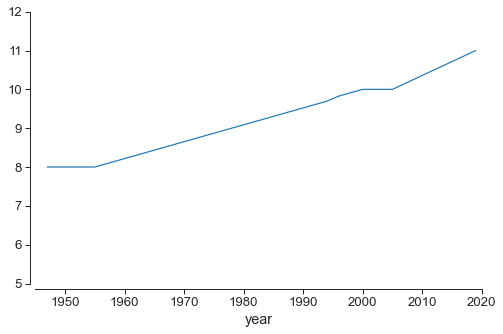

In [65]:
# Plot evolution of total glass thickness in IGUs:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu_thick.reset_index(),
             x='year', y='average thickness, mm',
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(5, 12)

sns.despine(offset=5)

In [66]:
# Taking into acount uncertainty, average thickness +-25%
df_eu_thick['max. thickness, mm'] = (
    df_eu_thick['average thickness, mm']*1.25)

df_eu_thick['min. thickness, mm'] = (
    df_eu_thick['average thickness, mm']*0.75)

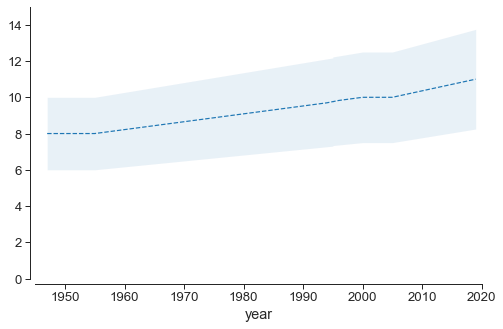

In [67]:
# Plot evolution of total glass thickness in IGUs w/ uncertainty:
df_toplot = df_eu_thick.reset_index('Nbr of countries').drop(
    labels='Nbr of countries', axis=1)


fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_toplot['average thickness, mm'],
             linestyle='--', ax=ax)

ax.fill_between(df_toplot.index, df_toplot['max. thickness, mm'],
                df_toplot['min. thickness, mm'],
                alpha=0.10)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15)

sns.despine(offset=5)

In [68]:
# Adding columns for IGU flows in [kt],
# to be used later for material/energy/carbon intensity

for level in ['average', 'min.', 'max.']:
    for flow in ['Import', 'Export', 'Production']:
        df_eu[(f'{flow}', f'[kt], {level}')] = (
            df_eu[(f'{flow}', '[10^6 m²]')] *
            df_eu_thick[f'{level} thickness, mm'] * 2.5)

In [69]:
df_eu = df_eu.sort_index(axis=1)

## Production of Insulating Glass Units

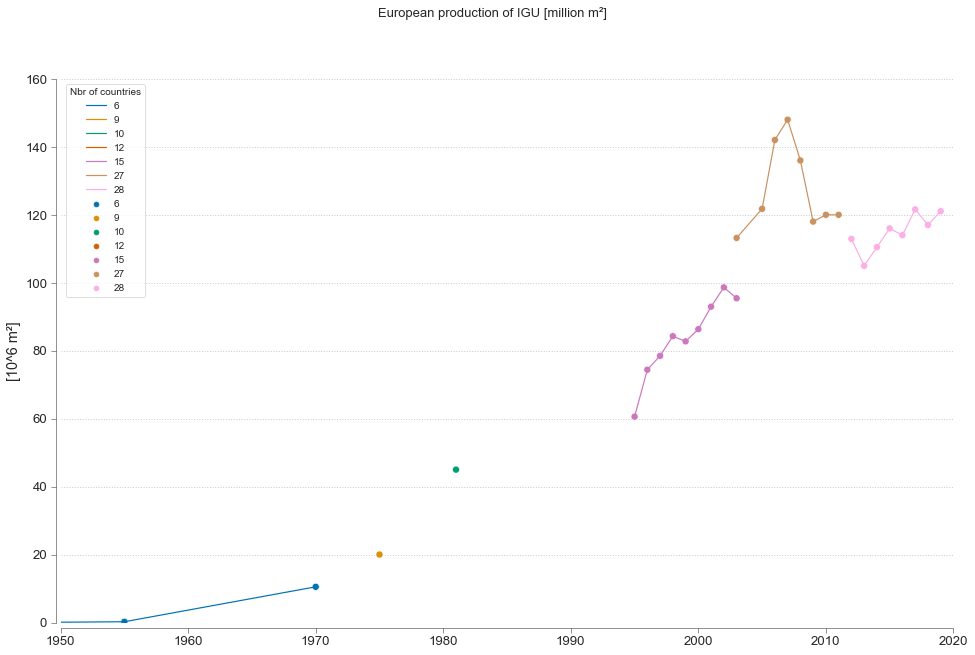

In [70]:
# Plot the European production of IGU
fig, ax = plt.subplots()

sns.scatterplot(data=df_eu['Production'].reset_index(),
                x='year', y='[10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind', s=50,
                ax=ax)

sns.lineplot(data=df_eu['Production'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

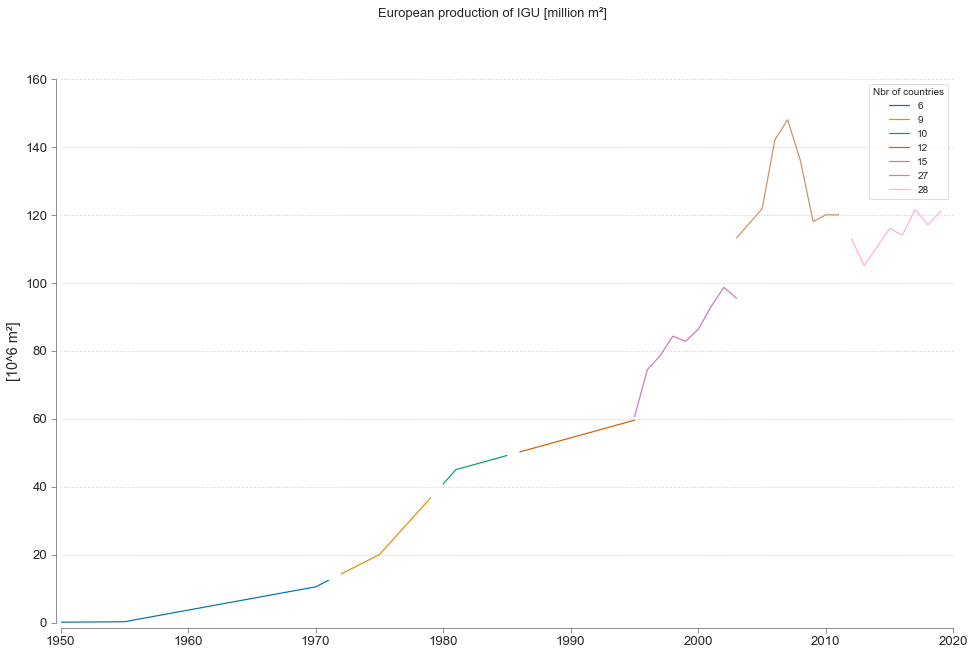

In [71]:
# Plot the European production of IGU:
fig, ax = plt.subplots()

sns.lineplot(data=(df_eu['Production']
                   .interpolate(method='linear').reset_index()),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

In [72]:
# Estimate the consumption of IGU in the EU:
df_eu = df_eu.stack(dropna=False)

df_eu['Consumption'] = (df_eu['Production']
                        + df_eu['Import']
                        - df_eu['Export']
                        )

df_eu = df_eu.unstack()

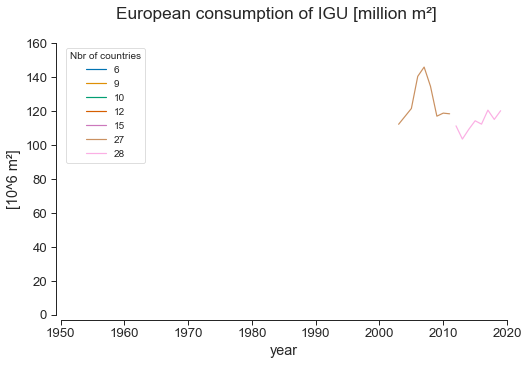

In [73]:
# Plot the European consumption of IGU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df_eu['Consumption'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

fig.suptitle('European consumption of IGU [million m²]')
sns.despine(offset=5)
plt.show()

## Summary

In [74]:
# Assess the annual growth:
df_eu[('Growth, prod', '[%]')] = df_eu[(
    'Production', '[10^6 m²]')].pct_change()

In [75]:
df_eu.loc[(slice(None), slice(2003, 2020)), :]

Info                     Export                                        Import  \
Unit                  [10^6 m²] [kt], average [kt], max. [kt], min. [10^6 m²]   
Nbr of countries year                                                           
15               2003       NaN           NaN        NaN        NaN       NaN   
27               2003      1.72         43.06      53.83      32.30      0.51   
                 2004      1.54         38.62      48.27      28.96      0.65   
                 2005      1.33         33.15      41.44      24.87      0.81   
                 2006      2.64         66.50      83.12      49.87      0.81   
                 2007      3.15         79.85      99.81      59.88      0.80   
                 2008      2.42         61.87      77.34      46.40      0.73   
                 2009      1.87         48.04      60.05      36.03      0.62   
                 2010      2.03         52.46      65.57      39.34      0.58   
                 2011      2.48         64.67      80.83      48.50      0.62   
28               2012      2.57         67.53      84.41      50.65      0.72   
                 2013      2.47         65.35      81.69      49.01      0.73   
                 2014      2.63         69.94      87.42      52.45      1.14   
                 2015      2.83         75.90      94.88      56.93      0.87   
                 2016      2.94         79.31      99.14      59.48      1.00   
                 2017      3.41         92.47     115.59      69.35      2.12   
                 2018      3.20         87.31     109.13      65.48      1.02   
                 2019      3.42         93.92     117.41      70.44      2.32   

Info                                                      Production  \
Unit                  [kt], average [kt], max. [kt], min.  [10^6 m²]   
Nbr of countries year                                                  
15               2003           NaN        NaN        NaN      95.43   
27               2003         12.74      15.93       9.56     113.19   
                 2004         16.16      20.19      12.12        NaN   
                 2005         20.34      25.43      15.26     121.77   
                 2006         20.39      25.49      15.30     142.03   
                 2007         20.40      25.50      15.30     148.00   
                 2008         18.70      23.37      14.02     136.00   
                 2009         15.90      19.88      11.93     118.00   
                 2010         14.95      18.69      11.21     120.00   
                 2011         16.26      20.32      12.19     120.00   
28               2012         18.96      23.69      14.22     112.90   
                 2013         19.26      24.08      14.45     105.00   
                 2014         30.38      37.98      22.79     110.47   
                 2015         23.41      29.26      17.56     116.00   
                 2016         27.01      33.77      20.26     114.00   
                 2017         57.48      71.84      43.11     121.60   
                 2018         27.86      34.83      20.90     117.01   
                 2019         63.74      79.68      47.81     121.06   

Info                                                      Consumption  \
Unit                  [kt], average [kt], max. [kt], min.   [10^6 m²]   
Nbr of countries year                                                   
15               2003       2385.64    2982.05    1789.23         NaN   
27               2003       2829.82    3537.27    2122.36      111.98   
                 2004           NaN        NaN        NaN         NaN   
                 2005       3044.24    3805.30    2283.18      121.26   
                 2006       3576.03    4470.03    2682.02      140.20   
                 2007       3752.86    4691.07    2814.64      145.66   
                 2008       3472.86    4341.07    2604.64      134.31   
                 2009       3034.29    3792.86    2275.

In [76]:
n_countries = df_eu.index.get_level_values(0).unique()

for i, start_n_countries in enumerate(n_countries[:-1]):
    if start_n_countries < 10:
        continue
    end_n_countries = n_countries[i+1]
    start_year = df_eu.loc[start_n_countries].index.max()
    end_year = df_eu.loc[end_n_countries].index.max()
    a = df_eu.loc[start_n_countries:end_n_countries,
                  ('Growth, prod', '[%]')].mean()*100

    print(
        f'Years {start_year}-{end_year} ({start_n_countries} to {end_n_countries} countries)')
    print(f'IGU production growth in EU: {a:.2f}%\n')
    print('')

Years 1985-1995 (10 to 12 countries)
IGU production growth in EU: 7.81%


Years 1995-2003 (12 to 15 countries)
IGU production growth in EU: 4.39%


Years 2003-2011 (15 to 27 countries)
IGU production growth in EU: 6.15%


Years 2011-2019 (27 to 28 countries)
IGU production growth in EU: 1.72%




In [77]:
n_countries

Int64Index([6, 9, 10, 12, 15, 27, 28], dtype='int64', name='Nbr of countries')

In [78]:
# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_KDATES = {'EU9': 1972, 'EU12': 1986,
             'EU15': 1995, 'EU27': 2003, 'EU28': 2012}

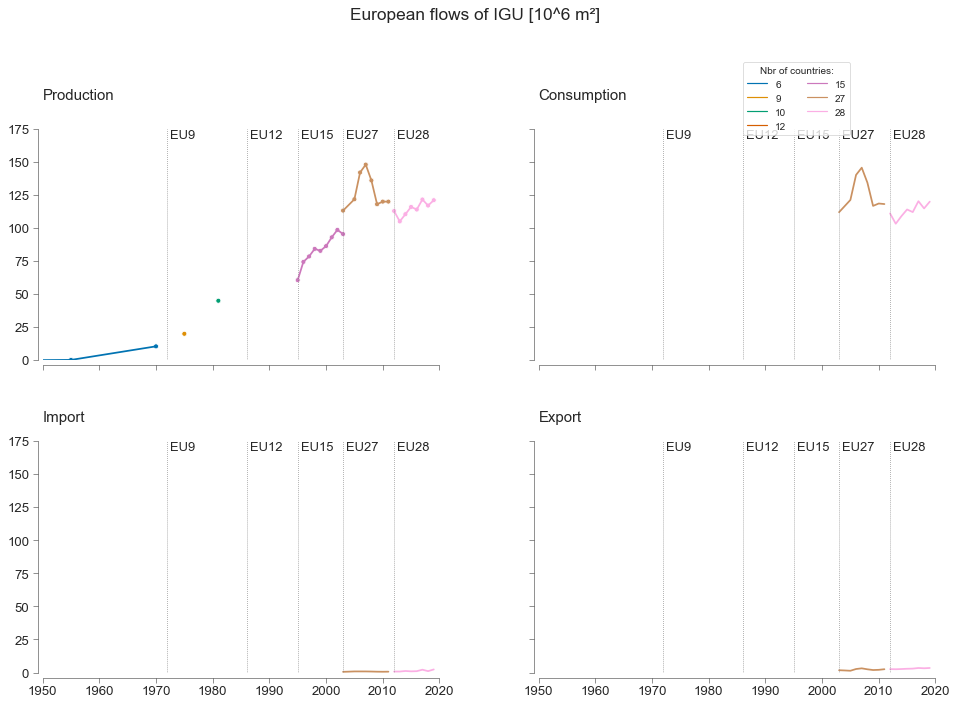

In [79]:
# Plot a synthesis of the results concerning European flows of IGU:
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

# Plot production and consumption:
for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=df_eu[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    if col == 0:
        # Plot data gathered from literature review:
        sns.scatterplot(data=df_eu[f"{data}"].reset_index(),
                        x='year', y="[10^6 m²]",
                        hue='Nbr of countries',
                        palette='colorblind',
                        marker='.', s=100,
                        ax=ax)

    ax.get_legend().remove()
    style_ax(ax)

    ax.set_title(f"{data}", pad=30, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    # ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)

# Plot import and export below:
for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=df_eu[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    style_ax(ax)

    ax.set_title(f"{data}", pad=20, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)


# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2,
           title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.98))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 175)

fig.suptitle("European flows of IGU [10^6 m²]", y=1.05)
fig.subplots_adjust(wspace=0.25, hspace=0.35)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_IGUFlows.pdf'),
                bbox_inches='tight')

Hypothesis for missing data: EU production = EU consumption

In [80]:
df_eu = df_eu.stack(dropna=False)
df_eu['Estimated consumption'] = (df_eu['Consumption']
                                  .fillna(df_eu['Production']))

df_eu = df_eu.unstack()

In [81]:
# Number of countries for trend curves:
EU_COUNTRIES = [(6, 12), (15, 15), (27, 28)]

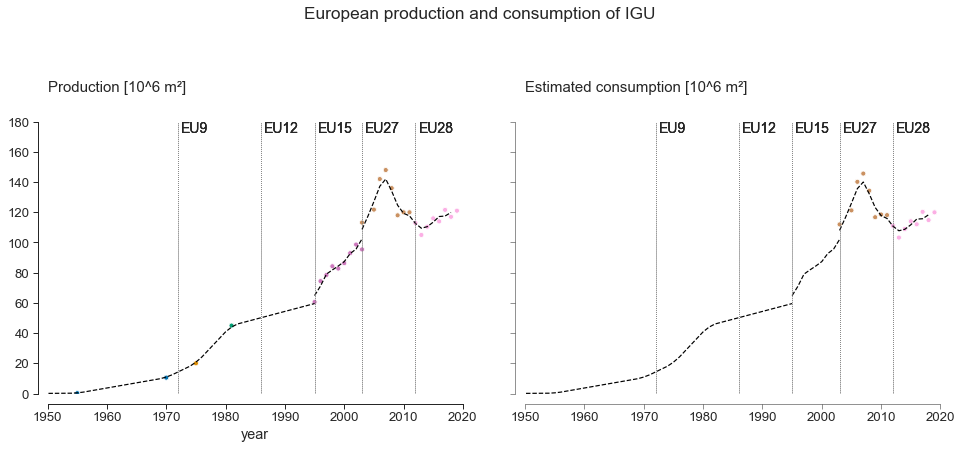

In [82]:
# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, data in enumerate(['Production', 'Estimated consumption']):
    for i, j in EU_COUNTRIES:
        ax = axes[col]
        # Plot the trend curve for IGU production:
        ax.plot(df_eu.interpolate().rolling(3, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{data}", "[10^6 m²]")],
                c='black', linestyle='--')

        if col == 0:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Production"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
        else:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Consumption"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)

        # Plot lines highlighting changes in the scope, i.e., EU enlargement:
        for y, x in EU_KDATES.items():
            ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
            ax.text(x+0.5, 180, f"{y}", fontsize=14,
                    verticalalignment='top')

        ax.get_legend().remove()
        ax.set_title(f'{data} [10^6 m²]', pad=30, loc='left')
        ax.yaxis.label.set_visible(False)

style_ax(ax)
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 180)

plt.suptitle('European production and consumption of IGU',
             weight='light', y=1.2)

fig.subplots_adjust(wspace=0.15)

sns.despine(offset=10)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.pdf'),
                bbox_inches='tight')

# Flows of Insulating Glass Units in France and Belgium

## Creating a Dataframe for the Flows of IGUs

In [83]:
# Create a DataFrame from production datasets:
df_fr_prod = fr_data.parse('prod').set_index('year')
df_be_prod = be_data.parse('prod').set_index('year')

In [84]:
# Create DataFrames from import and export datasets:
df_fr_imp = fr_data.parse('import').set_index('year')
df_fr_exp = fr_data.parse('export').set_index('year')

df_be_imp = be_data.parse('import').set_index('year')
df_be_exp = be_data.parse('export').set_index('year')

In [85]:
# Create a DataFrame for the average thickness:
df_fr_thick = fr_data.parse('thickness').set_index('year')
df_be_thick = be_data.parse('thickness').set_index('year')

In [86]:
# Create a DataFrame from consumption data, Belgium only:
df_fr_use = fr_data.parse('consumption').set_index('year')
df_be_use = be_data.parse('consumption').set_index('year')

In [87]:
# Create a new DataFrame for Belgian and French IGU flows:
df_be_fr = (
    pd.concat([df_fr_use['IGU, "000 m²']/1000,
               df_fr_prod['IGU, "000 m²']/1000,
               df_fr_imp['IGU, "000 m²']/1000,
               df_fr_exp['IGU, "000 m²']/1000,
               df_be_use['IGU, kt'],
               df_be_use['IGU, "000 m²']/1000,
               df_be_prod['IGU, kt'],
               df_be_prod['IGU, "000 m²']/1000,
               df_be_imp['IGU, kt'],
               df_be_imp['IGU, "000 m²']/1000,
               df_be_exp['IGU, kt'],
               df_be_exp['IGU, "000 m²']/1000],
              axis=1,
              keys=[('Consumption', '[10^6 m²]', 'France'),
                    ('Production', '[10^6 m²]', 'France'),
                    ('Import', '[10^6 m²]', 'France'),
                    ('Export', '[10^6 m²]', 'France'),
                    ('Consumption', '[kt]', 'Belgium'),
                    ('Consumption', '[10^6 m²]', 'Belgium'),
                    ('Production', '[kt]', 'Belgium'),
                    ('Production', '[10^6 m²]', 'Belgium'),
                    ('Import', '[kt]', 'Belgium'),
                    ('Import', '[10^6 m²]', 'Belgium'),
                    ('Export', '[kt]', 'Belgium'),
                    ('Export', '[10^6 m²]', 'Belgium')],
              names=['Info', 'Unit', 'Country'])).stack(level=- 1,
                                                        dropna=False)

df_be_fr = df_be_fr.unstack()

In [88]:
df_be_fr[20:35]

Info    Consumption                          Export                        \
Unit      [10^6 m²]           [kt]        [10^6 m²]           [kt]          
Country     Belgium France Belgium France   Belgium France Belgium France   
year                                                                        
1965            NaN    NaN     NaN    NaN       NaN    NaN    34.0    NaN   
1966            NaN    NaN     NaN    NaN       NaN    NaN    32.0    NaN   
1967            NaN    NaN     NaN    NaN       NaN    NaN    36.0    NaN   
1968            NaN    NaN     NaN    NaN       NaN    NaN    37.0    NaN   
1969            NaN    NaN     NaN    NaN       NaN    NaN    42.0    NaN   
1970           0.68   3.23     NaN    NaN       NaN    NaN    47.0    NaN   
1971           0.62    NaN     NaN    NaN       NaN    NaN    45.0    NaN   
1972           0.65    NaN     NaN    NaN       NaN    NaN    44.0    NaN   
1973           0.77    NaN     NaN    NaN       NaN    NaN    40.0    NaN   
1974           1.05    NaN     NaN    NaN       NaN    NaN    34.0    NaN   
1975           1.27    NaN     NaN    NaN       NaN    NaN    34.0    NaN   
1976           1.57    NaN     NaN    NaN       NaN    NaN    32.0    NaN   
1977           1.83    NaN     NaN    NaN       NaN    NaN    26.0    NaN   
1978           1.85   4.60     NaN    NaN       NaN    NaN    33.0    NaN   
1979           1.85    NaN     NaN    NaN       NaN    NaN    41.0    NaN   

Info       Import                       Production                        
Unit    [10^6 m²]           [kt]         [10^6 m²]           [kt]         
Country   Belgium France Belgium France    Belgium France Belgium France  
year                                                                      
1965          NaN    NaN     0.0    NaN        NaN    NaN     NaN    NaN  
1966          NaN    NaN     0.0    NaN        NaN    NaN     NaN    NaN  
1967          NaN    NaN     0.0    NaN        NaN    NaN     NaN    NaN  
1968          NaN    NaN     0.0    NaN        NaN    NaN     NaN    NaN  
1969          NaN    NaN     0.0    NaN        NaN    NaN     NaN    NaN  
1970          NaN    NaN     0.0    NaN        NaN   3.48     NaN    NaN  
1971          NaN    NaN     0.0    NaN        NaN   3.40     NaN    NaN  
1972          NaN    NaN     0.0    NaN        NaN   3.44     NaN    NaN  
1973          NaN    NaN     0.0    NaN        NaN   3.58     NaN    NaN  
1974          NaN    NaN     0.0    NaN        NaN   3.90     NaN    NaN  
1975          NaN    NaN     1.0    NaN        NaN   4.17     NaN    NaN  
1976          NaN    NaN     2.0    NaN        NaN   4.50     NaN    NaN  
1977          NaN    NaN     3.0    NaN        NaN   4.81     NaN    NaN  
1978          NaN    NaN     5.0    NaN        NaN   4.83     NaN    NaN  
1979          NaN    NaN     6.0    NaN        NaN    NaN     NaN    NaN

In [89]:
# Create a DataFrame for the evolution of the population:
fr_pop = fr_data.parse('Population').set_index('year')
be_pop = be_data.parse('Population').set_index('year')

In [90]:
# Create a unique DataFrame for French and Belgian population:
df_be_fr_pop = pd.concat([fr_pop['Population, x1000'],
                       be_pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

df_be_fr_pop = df_be_fr_pop.unstack()

## Average glass thickness of IGUs

As the data are either in t or in m² depending on the year, we estimate the flows for each unit according to the evolution of the average thickness.

In [91]:
# Create a new DataFrame for average thickness, BE and FR:
df_be_fr_thick = (
    pd.concat([df_fr_thick['average thickness, mm'],
               df_be_thick['average thickness, mm'], ],
              axis=1,
              keys=[('average thickness, mm', 'France'),
                    ('average thickness, mm', 'Belgium')],
              names=['Info', 'Country'])).stack(dropna=False)

df_be_fr_thick = df_be_fr_thick.unstack()

In [92]:
# Linear interpolation for the average thickness:
df_be_fr_thick = df_be_fr_thick.interpolate(method='linear',
                                            limit_area='inside')

In [93]:
# Taking into acount uncertainty, average thickness +-25%:
for country in countries:
    df_be_fr_thick[('max. thickness, mm', country)] = (
        df_be_fr_thick[('average thickness, mm', country)]*1.25)

    df_be_fr_thick[('min. thickness, mm', country)] = (
        df_be_fr_thick[('average thickness, mm', country)]*0.75)

df_be_fr_thick = df_be_fr_thick.sort_index(axis=1)

In [94]:
df_be_fr_thick

Info    average thickness, mm        max. thickness, mm         \
Country               Belgium France            Belgium France   
year                                                             
1945                      NaN    NaN                NaN    NaN   
1946                      8.0   8.00              10.00  10.00   
1947                      8.0   8.00              10.00  10.00   
1948                      8.0   8.00              10.00  10.00   
1949                      8.0   8.00              10.00  10.00   
...                       ...    ...                ...    ...   
2016                     11.0   9.89              13.75  12.37   
2017                     11.0   9.93              13.75  12.41   
2018                     11.0   9.96              13.75  12.46   
2019                     11.0  10.00              13.75  12.50   
2020                      NaN    NaN                NaN    NaN   

Info    min. thickness, mm         
Country            Belgium France  
year                               
1945                   NaN    NaN  
1946                  6.00   6.00  
1947                  6.00   6.00  
1948                  6.00   6.00  
1949                  6.00   6.00  
...                    ...    ...  
2016                  8.25   7.42  
2017                  8.25   7.45  
2018                  8.25   7.47  
2019                  8.25   7.50  
2020                   NaN    NaN  

[76 rows x 6 columns]

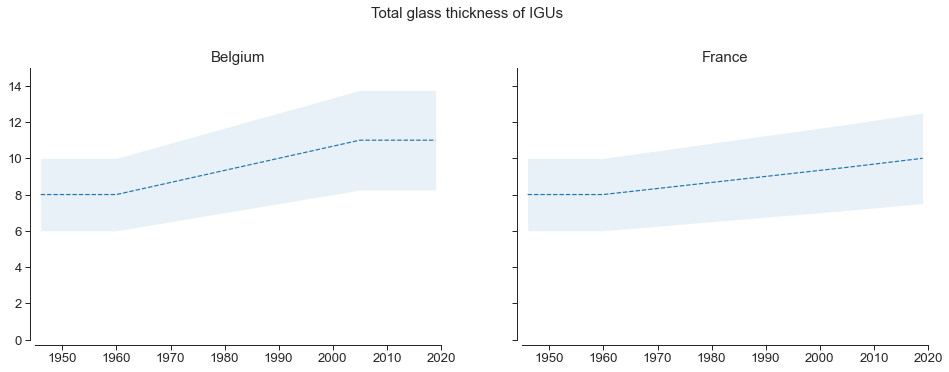

In [95]:
# Plot evolution of total glass thickness of IGUs:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    sns.lineplot(data=df_be_fr_thick[('average thickness, mm', country)],
                 linestyle='--', ax=ax)

    ax.fill_between(df_be_fr_thick.index,
                    df_be_fr_thick[('max. thickness, mm', country)],
                    df_be_fr_thick[('min. thickness, mm', country)],
                    alpha=0.10)

    ax.set_title(country)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15)

fig.suptitle('Total glass thickness of IGUs', fontsize=15, y=1.05)

sns.despine(offset=5)

## Post-Processing the flows of IGUs

Estimation of missing date:
- Production = consumption + export - import

- Consumption = production + import - export

In [96]:
# Estimation of missing data according to units available:
# Production:
df_be_fr['Production'] = (
    df_be_fr['Production'].fillna(
        df_be_fr['Consumption']+df_be_fr['Export']-df_be_fr['Import']))

# Consumption:
df_be_fr['Consumption'] = (
    df_be_fr['Consumption'].fillna(
        df_be_fr['Production'] + df_be_fr['Import']-df_be_fr['Export']))

df_be_fr = df_be_fr.sort_index(axis=1)

In [97]:
# Stock raw data in a new Dataframe:
df_be_fr_init = df_be_fr

For Belgium, the data is either in m², tonnes or both. To "harmonise" the time series, the missing values are estimated from the average thickness of glass per IGU:

In [98]:
# Estimation of total flows per m² according to values in kt:
for flow in ['Consumption', 'Production', 'Export', 'Import']:
    # Conditions for calculating missing data according to units available:
    has_kt = df_be_fr[(f'{flow}', '[kt]', 'Belgium')].notna()
    has_m2 = df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')].notna()

    # Calculating missing values flows according to thickness:
    df_be_fr.loc[has_kt & ~has_m2, (
        f'{flow}', '[10^6 m²]', 'Belgium')] = (
        df_be_fr.loc[has_kt & ~has_m2, (
            f'{flow}', '[kt]', 'Belgium')]
        / df_be_fr_thick[('average thickness, mm', 'Belgium')] / 2.5)

In [99]:
# Estimation of total flows per kt according to values in m²:
for flow in ['Consumption', 'Production', 'Export', 'Import']:
    # Conditions for calculating missing data according to units available:
    has_kt = df_be_fr[(f'{flow}', '[kt]', 'Belgium')].notna()
    has_m2 = df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')].notna()

    # Calculating flows if missing according to thickness:
    df_be_fr.loc[has_m2 & ~has_kt, (
        f'{flow}', '[kt]', 'Belgium')] = (
        df_be_fr.loc[has_m2 & ~has_kt, (
            f'{flow}', '[10^6 m²]', 'Belgium')]
        * df_be_fr_thick[('average thickness, mm', 'Belgium')] * 2.5)

In [100]:
# Estimation of missing data according to units available:
# Production:
df_be_fr['Production'] = (
    df_be_fr['Production'].fillna(
        df_be_fr['Consumption']+df_be_fr['Export']-df_be_fr['Import']))

# Consumption:
df_be_fr['Consumption'] = (
    df_be_fr['Consumption'].fillna(
        df_be_fr['Production'] + df_be_fr['Import']-df_be_fr['Export']))

df_be_fr = df_be_fr.sort_index(axis=1)

Weighing the flows of IGUs, France (i.e. from Mm² to kt):

In [101]:
# Estimating total weight of the flows of IGUs [kt], France (raw data in m²)
# to be used later for material/energy/carbon intensity
for flow in ['Consumption', 'Import', 'Export', 'Production']:
    df_be_fr[(f'{flow}', '[kt]', 'France')] = (
        df_be_fr[(f'{flow}', '[10^6 m²]', 'France')]
        * df_be_fr_thick[('average thickness, mm', 'France')] * 2.5)

In [102]:
df_be_fr[20:40]

Info    Consumption                          Export                        \
Unit      [10^6 m²]           [kt]        [10^6 m²]           [kt]          
Country     Belgium France Belgium France   Belgium France Belgium France   
year                                                                        
1965            NaN    NaN     NaN    NaN      1.63    NaN    34.0    NaN   
1966            NaN    NaN     NaN    NaN      1.52    NaN    32.0    NaN   
1967            NaN    NaN     NaN    NaN      1.70    NaN    36.0    NaN   
1968            NaN    NaN     NaN    NaN      1.73    NaN    37.0    NaN   
1969            NaN    NaN     NaN    NaN      1.95    NaN    42.0    NaN   
1970           0.68   3.23   14.73  67.19      2.17    NaN    47.0    NaN   
1971           0.62    NaN   13.54    NaN      2.06    NaN    45.0    NaN   
1972           0.65    NaN   14.30    NaN      2.00    NaN    44.0    NaN   
1973           0.77    NaN   17.07    NaN      1.80    NaN    40.0    NaN   
1974           1.05    NaN   23.45    NaN      1.52    NaN    34.0    NaN   
1975           1.27    NaN   28.69    NaN      1.51    NaN    34.0    NaN   
1976           1.57    NaN   35.59    NaN      1.41    NaN    32.0    NaN   
1977           1.83    NaN   41.78    NaN      1.14    NaN    26.0    NaN   
1978           1.85   4.60   42.55  98.90      1.43    NaN    33.0    NaN   
1979           1.85    NaN   42.86    NaN      1.77    NaN    41.0    NaN   
1980           2.50    NaN   58.33    NaN      2.31    NaN    54.0    NaN   
1981           2.10    NaN   49.35    NaN      1.66    NaN    39.0    NaN   
1982           1.90    NaN   44.97    NaN      1.23    NaN    29.0    NaN   
1983            NaN    NaN     NaN    NaN      1.05    NaN    25.0    NaN   
1984            NaN    NaN     NaN    NaN      1.00    NaN    24.0    NaN   

Info       Import                       Production                         
Unit    [10^6 m²]           [kt]         [10^6 m²]           [kt]          
Country   Belgium France Belgium France    Belgium France Belgium  France  
year                                                                       
1965         0.00    NaN     0.0    NaN        NaN    NaN     NaN     NaN  
1966         0.00    NaN     0.0    NaN        NaN    NaN     NaN     NaN  
1967         0.00    NaN     0.0    NaN        NaN    NaN     NaN     NaN  
1968         0.00    NaN     0.0    NaN        NaN    NaN     NaN     NaN  
1969         0.00    NaN     0.0    NaN        NaN    NaN     NaN     NaN  
1970         0.00    NaN     0.0    NaN       2.85   3.48   61.73   72.40  
1971         0.00    NaN     0.0    NaN       2.68   3.40   58.54   71.22  
1972         0.00    NaN     0.0    NaN       2.65   3.44   58.30   72.24  
1973         0.00    NaN     0.0    NaN       2.57   3.58   57.07   75.48  
1974         0.00    NaN     0.0    NaN       2.57   3.90   57.45   82.55  
1975         0.04    NaN     1.0    NaN       2.74   4.17   61.69   88.51  
1976         0.09    NaN     2.0    NaN       2.89   4.50   65.59   96.11  
1977         0.13    NaN     3.0    NaN       2.84   4.81   64.78  102.95  
1978         0.22    NaN     5.0    NaN       3.07   4.83   70.55  103.84  
1979         0.26    NaN     6.0    NaN       3.36    NaN   77.86     NaN  
1980         0.39    NaN     9.0    NaN       4.43    NaN  103.33     NaN  
1981         0.34    NaN     8.0    NaN       3.42    NaN   80.35     NaN  
1982         0.30    NaN     7.0    NaN       2.83   4.18   66.97   91.35  
1983         0.25    NaN     6.0    NaN        NaN   4.85     NaN  106.30  
1984         0.21    NaN     5.0    NaN        NaN   4.43     NaN   97.44

## Production of Insulating Glass Units

Text(0.5, 1.1, 'IGU production [million m²/y]')

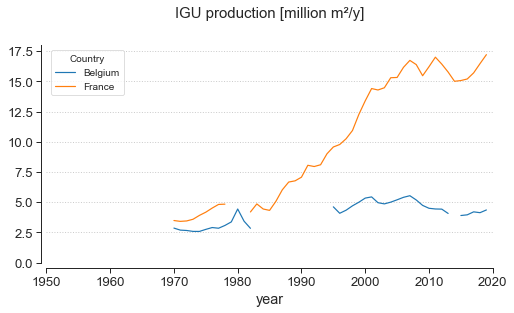

In [103]:
# Plot the BE and FR production of IGUs:
fig, ax = plt.subplots(figsize=(8, 4))

df_be_fr[('Production', '[10^6 m²]')].plot(ax=ax)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 18)

sns.despine(offset=5)
ax.set_title('IGU production [million m²/y]', y=1.1)

Text(0.5, 1.1, 'IGU production [million m²/y]')

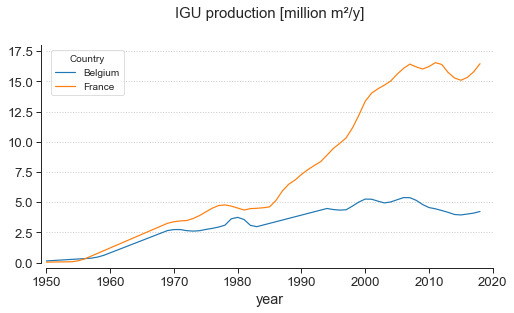

In [104]:
# Plot the moving average of the IGU production in BE and FR:
fig, ax = plt.subplots(figsize=(8, 4))

df_be_fr[('Production', '[10^6 m²]')].interpolate(
    method="linear", limit_area='inside').rolling(
    3, center=True).mean().plot(ax=ax)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 18)

sns.despine(offset=5)
ax.set_title('IGU production [million m²/y]', y=1.1)

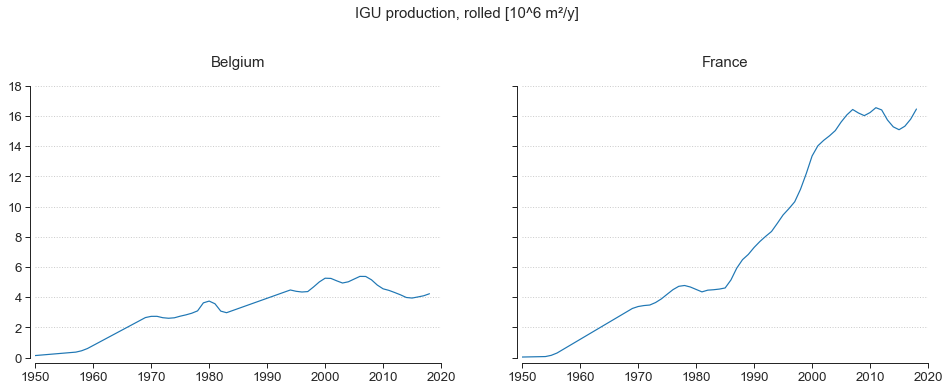

In [105]:
# Plot a moving average for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(df_be_fr.index,
            df_be_fr[('Production', '[10^6 m²]')][country]
            # Linear interpolation for IGU production:
            .interpolate(method="linear", limit_area='inside')
            # Rolling IGU production according to a 3-year mean:
            .rolling(3, center=True).mean())

    ax.set_title(country, y=1.05)
    ax.set_xlim(1950, 2020)
    ax.set_ylim(0, 18)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('IGU production, rolled [10^6 m²/y]', fontsize=15, y=1.1)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

Text(0.5, 1.1, 'Consumption of IGUs [million m²/y]')

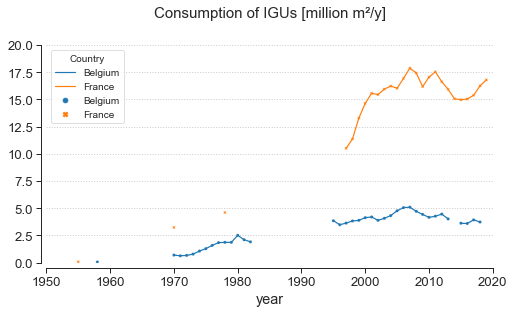

In [121]:
# Plot the BE and FR production of IGUs:
fig, ax = plt.subplots(figsize=(8, 4))

df_be_fr[('Consumption', '[10^6 m²]')].plot(ax=ax)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

sns.scatterplot(data=df_be_fr['Consumption', '[10^6 m²]'],
                        marker='.', s=10, color='grey',
                        ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)

sns.despine(offset=5)
ax.set_title('Consumption of IGUs [million m²/y]', y=1.1)

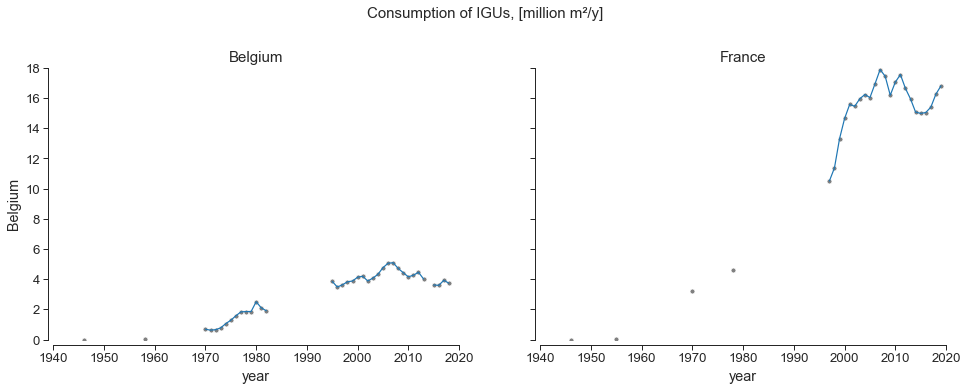

In [108]:
# Plot total consumption of IGU:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(df_be_fr.index,
            df_be_fr['Consumption', '[10^6 m²]'][country])
    ax.set_title(country)
    
    sns.scatterplot(data=df_be_fr['Consumption', '[10^6 m²]'][country],
                        marker='.', s=100, color='grey',
                        ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 18)

fig.suptitle('Consumption of IGUs, [million m²/y]', fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

Given the scarcity of data on the consumption of insulating glass units in France, and considering the low level of exports and imports over the study period, we assume that the production is roughly equivalent to the consumption when data is missing. Please refer to the article for a detailed discussion of this hypothesis.

In [126]:
df_be_fr['Consumption', '[kt]', 'France']

year
1945       NaN
1946      0.00
1947       NaN
1948       NaN
1949       NaN
         ...  
2016    371.76
2017    381.94
2018    404.74
2019    420.00
2020       NaN
Name: (Consumption, [kt], France), Length: 76, dtype: float64

In [131]:
# Estimation of missing data relating to the consumption of IGU:
for unit in ['[kt]', '[10^6 m²]']:
    df_be_fr['Consumption', unit, 'France'] = (
        df_be_fr['Consumption', unit, 'France'].fillna(
            df_be_fr['Production', unit, 'France']))

Text(0.5, 1.1, 'Consumption of IGU, 3-y rolled [million m²/y]')

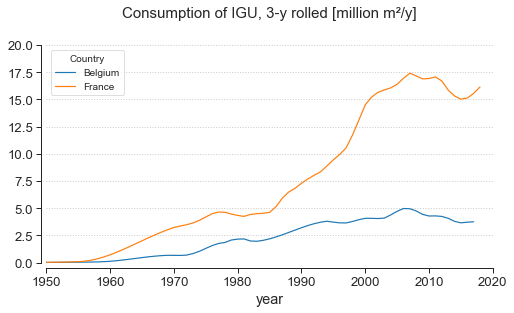

In [132]:
# Linear interpolation for IGU consumption
# and moving average with a 3-year window length:
fig, ax = plt.subplots(figsize=(8, 4))

(df_be_fr[('Consumption', '[10^6 m²]')]
 .interpolate(method="pchip", limit_area='inside')
 .rolling(3, center=True).mean().plot(ax=ax))

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)

sns.despine(offset=5)
ax.set_title('Consumption of IGU, 3-y rolled [million m²/y]', y=1.1)

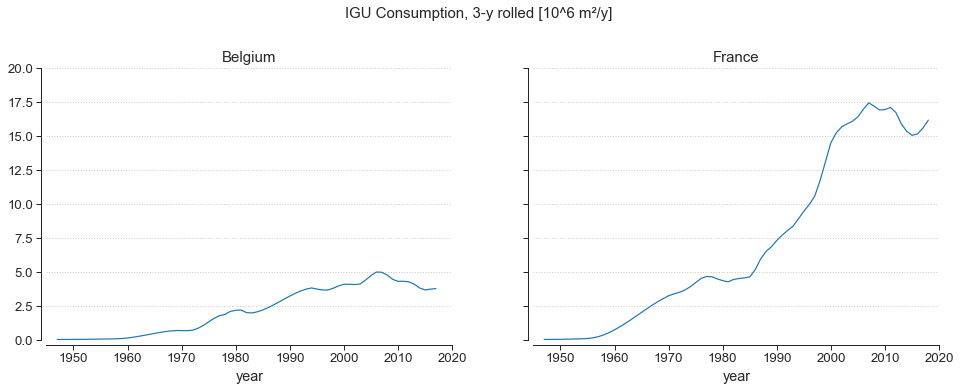

In [133]:
# Linear interpolation for IGU consumption
# and moving average with a 3-year window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    (df_be_fr['Consumption', '[10^6 m²]'][country]
     .interpolate(method="pchip", limit_area='inside')
     .rolling(3, center=True).mean()).plot(ax=ax)
    
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 20)

fig.suptitle('IGU Consumption, 3-y rolled [10^6 m²/y]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

Estimation of the consumption of IGU per capita in BE and FR:

In [134]:
# Estimating the IGU consumption per capita
for country in countries:
    df_be_fr[('Consumption', '[m²/cap]', country)] = (
        df_be_fr[('Consumption', '[10^6 m²]', country)]
        .interpolate(method='pchip', limit_area="inside")*1000
        / df_be_fr_pop[('Population [x1000]', country)]
        .interpolate(method='pchip', limit_area="inside"))

df_be_fr = df_be_fr.sort_index(axis=1)

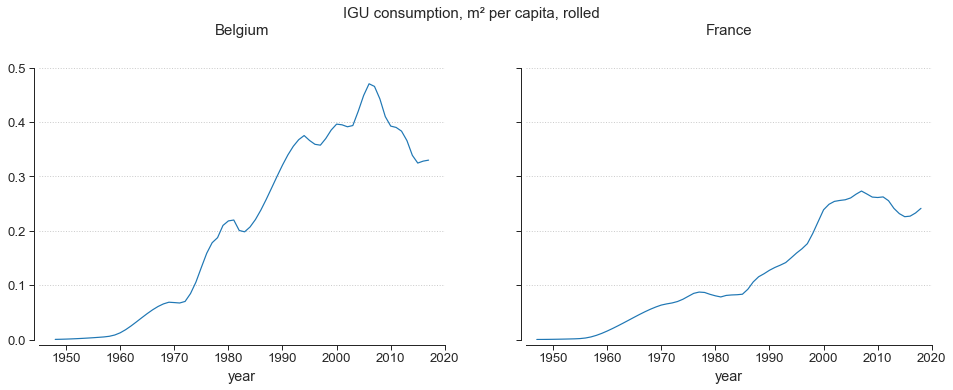

In [135]:
# Linear interpolation for IGU consumption per capita
# and moving average with a 3-y. window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    (df_be_fr['Consumption', '[m²/cap]'][country]
     .interpolate(method="pchip", limit_area='inside')
     .rolling(3, center=True).mean()).plot(ax=ax)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country, y=1.1)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 0.5)

fig.suptitle('IGU consumption, m² per capita, rolled',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [136]:
df_be_fr = df_be_fr.drop('[m²/cap]', axis=1, level=1)

## Summary

In [137]:
df_be_fr['Consumption'].describe()

Unit    [10^6 m²]           [kt]        
Country   Belgium France Belgium  France
count       38.00  49.00   38.00   49.00
mean         2.99  10.11   79.06  238.00
std          1.54   5.63   44.07  140.30
min          0.00   0.00    0.00    0.00
25%          1.83   4.60   41.98   98.90
50%          3.67   9.56   99.30  219.15
75%          4.14  15.93  111.93  380.50
max          5.09  17.88  139.84  427.75

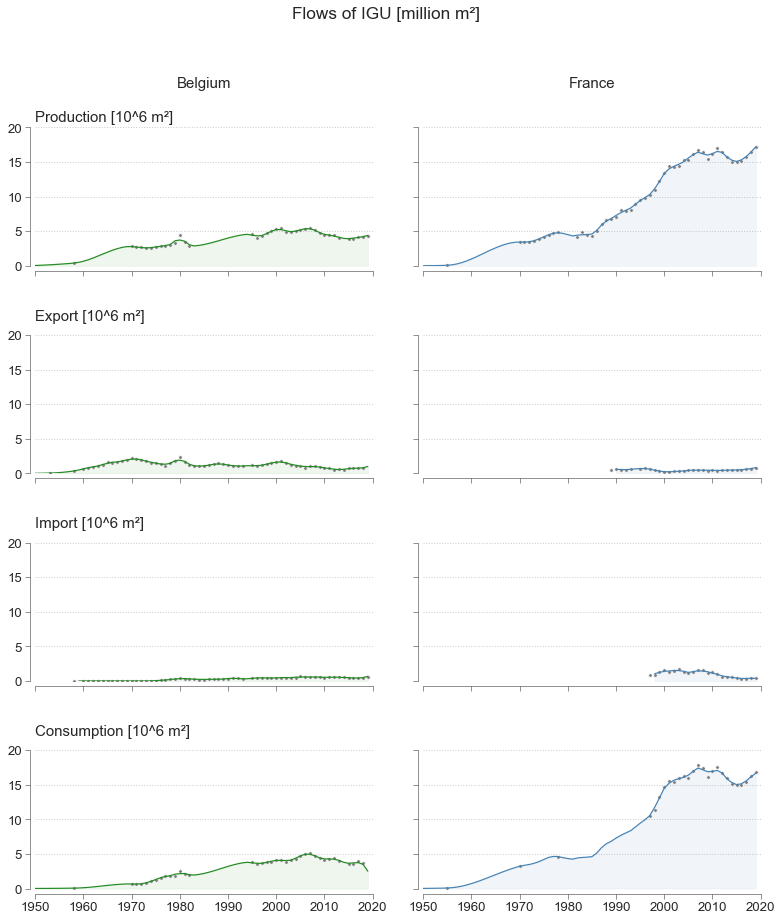

In [138]:
# Plot total flows, moving average w/ a 3-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{data} [10^6 m²]", loc='left', pad=15)
        else:
            color = 'steelblue'

        (df_be_fr[(data, "[10^6 m²]", country)]
         .interpolate(method='pchip')
         .rolling(3, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = df_be_fr.index
        y = (df_be_fr[(data, "[10^6 m²]", country)]
             .interpolate(method='pchip')
             .rolling(3, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        # Plot raw data:
        sns.scatterplot(data=df_be_fr_init[data, "[10^6 m²]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of IGU [million m²]", y=1)
sns.despine(offset=5)

plt.show()

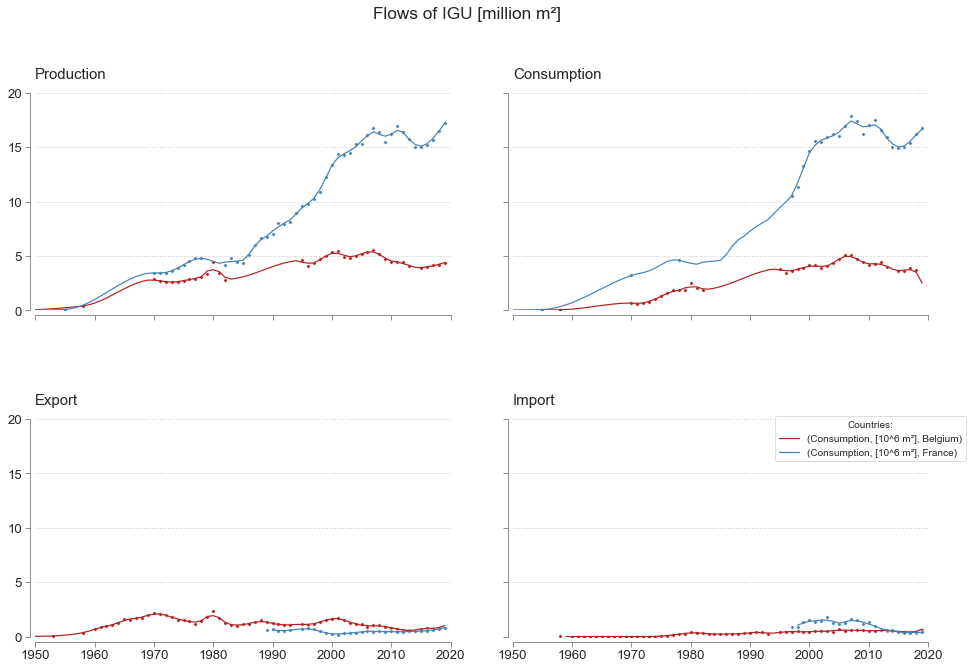

In [139]:
# Plot total flows, moving average w/ a 3-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for data in toplot:
    if data == "Production":
        ax = axes[0][0]
    if data == "Consumption":
        ax = axes[0][1]
    if data == "Export":
        ax = axes[1][0]
    if data == "Import":
        ax = axes[1][1]

    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{data}", loc='left', pad=15)
        else:
            color = 'steelblue'

        (df_be_fr[(data, "[10^6 m²]", country)]
         .interpolate(method='pchip')
         .rolling(3, center=True).mean()
         .plot(ax=ax, c=color)
         )

        # Plot raw data:
        sns.scatterplot(data=df_be_fr_init[data, "[10^6 m²]", country],
                        marker='.', s=50, color=color,
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 20)
plt.yticks(np.arange(0, 21, 5))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=1,
           title='Countries:',
           bbox_to_anchor=(0.85, 0.4))  # (0.83, 0.98)

fig.suptitle("Flows of IGU [million m²]", y=1)
sns.despine(offset=5)

plt.show()

# The Environmental Footprint Relating to the Production (and consumption) of IGU in the EU

## Raw Material Use for IGU Production

In [ ]:
# Absolute use of raw materials for IGU production:
for material in materials:
    eu_igu[(f"{material}, IGU production", '[kt]')] = (
        eu_igu[('Production', '[kt]')]
        * (df_rawmat[(f"{material}, kg/kg")]
           .interpolate(method='pchip', limit_direction='forward'))
    )

In [ ]:
# Plot raw material flows for IGU production in the EU:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=eu_igu[f"{material}, IGU production"].reset_index(),
                 x='year', y='[kt]',
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(material)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows related to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot raw material flows for EU IGU production
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    for a, b in eu_list:
        ax.plot(eu_igu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{material}, IGU production", '[kt]')],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(material)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Estimate total use of raw materials (sum per material):
eu_igu[('Total raw materials, IGU production', '[Mt]')] = 0

for material in materials:
    eu_igu[('Total raw materials, IGU production', '[Mt]')] = (
        eu_igu[(f"{material}, IGU production", '[kt]')]/1000
        + eu_igu[('Total raw materials, IGU production', '[Mt]')]
    )

In [ ]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['Total raw materials, IGU production'].reset_index(),
             x='year', y='[Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 4)
ax.set_ylabel(None)
style_ax(ax)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in eu_list:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, IGU production', '[Mt]')],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 4)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy use for the production of IGU

In [ ]:
# Absolute use of energy for IGU production:
for energy in energies:
    eu_igu[(f"{energy}, IGU production", '[PJ]')] = (
        eu_igu[('Production', '[kt]')]
        * (energy_intensity[f"{energy}, GJ/t"]
           .interpolate(method='pchip', limit_direction='forward'))/1000
    )

In [ ]:
# Plot energy used for IGU production in EU:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=eu_igu[f"{energy}, IGU production"].reset_index(),
                 x='year', y="[PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(energy)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)

fig.suptitle("Energy used in the production of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot energy flows for IGU production, 5-y rolled:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in eu_list:
        ax.plot(eu_igu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, IGU production", '[PJ]')],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(energy)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]",
             y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
eu_igu[('Total energy, IGU production', '[PJ]')] = 0

for energy in energies:
    eu_igu[('Total energy, IGU production', '[PJ]')] = (
        eu_igu[(f"{energy}, IGU production", '[PJ]')]
        + eu_igu[('Total energy, IGU production', '[PJ]')]
    )

In [ ]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['Total energy, IGU production'].reset_index(),
             x='year', y='[PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 40)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in eu_list:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, IGU production', '[PJ]')],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 emissions relating to the production of IGU, EU

In [ ]:
# Estimating the co2 emission related to IGU production
eu_igu[('co2, IGU production', '[kt]')] = (
    eu_igu[('Production', '[kt]')]
    * co2_intensity['CO2 interpolated [kg/t]'] / 1000
)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['co2, IGU production'].reset_index(),
             x='year', y='[kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 2000)
ax.get_legend().remove()

fig.suptitle("co2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in eu_list:
    ax.plot(eu_igu.rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, IGU production', '[kt]')],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1800)

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Summary

In [ ]:
# Number of countries for trend curves:
c = [(6, 12), (10, 15), (27, 28)]

In [ ]:
# Plot the absolute use of raw materials for IGU prod in the EU:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    for a, b in c:
        ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{material}, IGU production", '[kt]'],
                linewidth=1.1, c='sandybrown', linestyle='-')

    x = (eu_igu.reset_index()['year'])
    y = (eu_igu[(f"{material}, IGU production", '[kt]')].interpolate()
         .rolling(5, center=True).mean())

    ax.fill_between(x, y, color="sandybrown", alpha=0.1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {material}", loc='left')
    style_ax(ax)

ax.set_ylim(0, 2000)
ax.set_xlim(1950, 2020)
plt.yticks(np.arange(0, 2001, 500))
plt.xticks(np.arange(1950, 2021, 10))

# Divide by 1000 the y-axis, results in Mt:
ax.yaxis.set_major_formatter(y_1000)

fig.suptitle("(a) Use of raw materials [Mt]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of raw materials.pdf'),
                bbox_inches='tight')

plt.show()

In [ ]:
# Plot the absolute use of energy in the EU for architectural glass prod:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in c:
        ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, IGU production", '[PJ]')],
                linewidth=1.1, c='steelblue', linestyle='-')

    x = (eu_igu.reset_index()['year'])
    y = (eu_igu[(f"{energy}, IGU production", '[PJ]')].interpolate()
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="steelblue", alpha=0.10)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {energy}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 25)
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(b) Use of energy [PJ]", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of energy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of energy.pdf'),
                bbox_inches='tight')

plt.show()

In [ ]:
# Plot total energy and material use, and total CO2 emissions for IGU prod:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Total use of raw materials:
ax = axes[0]
for a, b in c:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, IGU production', '[Mt]')],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_igu.reset_index()['year'])
y = (eu_igu[('Total raw materials, IGU production', '[Mt]')].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Raw material use [Mt]", loc='left')
style_ax(ax)
ax.set_ylim(0, 4)
ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

# Total use of energy:
ax = axes[1]
for a, b in c:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, IGU production', '[PJ]')],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_igu.reset_index()['year'])
y = (eu_igu[('Total energy, IGU production', '[PJ]')].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Energy use [PJ]", loc='left')
style_ax(ax)
ax.set_ylim(0, 40)

# Total emissions of CO2:
ax = axes[2]
for a, b in c:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, IGU production', '[kt]')],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_igu.reset_index()['year'])
y = (eu_igu[('co2, IGU production', '[kt]')].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

# Divide by 1000 the y-axis, results in Mt
ax.yaxis.set_major_formatter(y_1000)

ax.set_title("CO2 emissions [MtCO2]", loc='left')
style_ax(ax)
ax.set_ylim(0, 2000)

fig.suptitle("(c) Total flows of raw materials, energy and CO2",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig5_EU_Total flows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig5_EU_Total flows.pdf'),
                bbox_inches='tight')

plt.show()

# The Environmental Footprint of IGU used in BE and FR

## Raw Material Use for IGU Production

In [ ]:
# Absolute use of raw materials for IGU consumption:
for mat in materials:
    for country in be_fr_igu[('Estimated consumption', '[kt]')].columns:
        be_fr_igu[(f"{mat}, IGU consum", '[kt]', country)] = (
            be_fr_igu[('Estimated consumption', '[kt]', country)]
            * (df_rawmat[(f"{mat}, kg/kg")]
               .interpolate(method='pchip', limit_direction='forward'))
        )

In [ ]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, mat in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(mat)
        be_fr_igu[(f"{mat}, IGU consum", '[kt]', country)].plot(ax=ax)

ax.set_xlim(1950, 2020)

sns.despine()
plt.show()

In [ ]:
for country in countries:
    be_fr_igu[('Total raw material use, IGU consum', '[kt]', country)] = 0

for mat in materials:
    be_fr_igu['Total raw material use, IGU consum', '[kt]'] = (
        be_fr_igu[f"{mat}, IGU consum", '[kt]']
        + be_fr_igu[('Total raw material use, IGU consum', '[kt]')]
    )

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total raw material use, IGU consum', '[kt]', country)]
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 500)
sns.despine()
plt.show()

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total raw material use, IGU consum', '[kt]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 500)
sns.despine()
plt.show()

## Energy use for IGU Production

In [ ]:
# Absolute use of energy for IGU production:
for energy in energies:
    for country in countries:
        be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)] = (
            be_fr_igu[('Estimated consumption', '[kt]', country)]
            * (energy_intensity[(f"{energy}, GJ/t")]
               .interpolate(method='pchip', limit_direction='forward'))
        )

In [ ]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)].plot(ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(ymin=0)

sns.despine()
plt.show()

In [ ]:
# Total energy use for IGU production (sum of energy sources):
for country in countries:
    be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)] = 0

for energy in energies:
    be_fr_igu[('Total energy use, IGU consum', '[TJ]')] = (
        be_fr_igu[f"{energy}, IGU consum", '[TJ]']
        + be_fr_igu[('Total energy use, IGU consum', '[TJ]')]
    )

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 5000)
sns.despine()
plt.show()

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 5000)
sns.despine()
plt.show()

## CO2 emissions Relating to IGU Consumption in France and Belgium

In [ ]:
# Estimating the CO2 emission related to IGU consumption
for country in be_fr_igu[('Estimated consumption', '[kt]')].columns:
    be_fr_igu[('CO2, IGU consum', '[ktCO2]', country)] = (
        be_fr_igu[('Estimated consumption', '[kt]', country)]
        * co2_intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
# Estimating the CO2 emission related to IGU production
for country in be_fr_igu[('Production', '[kt]')].columns:
    be_fr_igu[('CO2, IGU production', '[ktCO2]', country)] = (
        be_fr_igu[('Production', '[kt]', country)]
        * co2_intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
co2_igu = ['production', 'consum']

In [ ]:
nrows = len(co2_igu)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, co2 in enumerate(co2_igu):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(co2)
        be_fr_igu[(f"CO2, IGU {co2}", '[ktCO2]', country)].plot(ax=ax)

ax.set_xlim(1950, 2020)

sns.despine()
plt.show()

In [ ]:
nrows = len(co2_igu)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, co2 in enumerate(co2_igu):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(co2)
        (be_fr_igu[(f"CO2, IGU {co2}", '[ktCO2]', country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax))

ax.set_xlim(1950, 2020)

sns.despine()
plt.show()

## Summary

In [ ]:
# Raw materials, per type:
mat_reduced = ['sand', 'cullet', 'sodium carbonate']

nrows = len(mat_reduced)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for row, material in enumerate(mat_reduced):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if country == 'Belgium':
            color = 'sandybrown'
            ax.set_title(f" {material}", loc='left')
        else:
            color = 'saddlebrown'

        (be_fr_igu[(f"{material}, IGU consum", '[kt]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color))

        x = be_fr_igu.index
        y = (be_fr_igu[(f"{material}, IGU consum", '[kt]', country)]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color="sandybrown", alpha=0.1)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        if row == 0:
            ax.set_title(country, y=1.2)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 250)
plt.xticks(np.arange(1950, 2021, 10))
plt.yticks(np.arange(0, 251, 50))

fig.suptitle("(a) Use of raw materials, per type [kt]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Use of raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Use of raw materials.pdf'),
                bbox_inches='tight')

In [ ]:
# Raw materials, total:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr_igu[("Total raw material use, IGU consum", '[kt]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr_igu.index
    y = (be_fr_igu[("Total raw material use, IGU consum", '[kt]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

ax.set_ylim(0, 500)
plt.yticks(np.arange(0, 501, 100))

fig.suptitle("(b) Use of raw materials, total [kt]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Total raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Total raw materials.pdf'),
                bbox_inches='tight')

In [ ]:
# Energy use, per type:
nrows = len(energies)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if country == 'Belgium':
            color = 'cornflowerblue'
            ax.set_title(f" {energy}", loc='left')
        else:
            color = 'darkblue'

        (be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = be_fr_igu.index
        y = (be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color="steelblue", alpha=0.1)

        # Divide by 1000 the y-axis, results in PJ
        ax.yaxis.set_major_formatter(y_1000)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        if row == 0:
            ax.set_title(country, y=1.2)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3000)

plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(a) Use of energy, per type [PJ]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Use of energy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Use of energy.pdf'),
                bbox_inches='tight')

In [ ]:
# Energy use, total:
fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr_igu.index
    y = (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    # Divide by 1000 the y-axis, results in PJ
    ax.yaxis.set_major_formatter(y_1000)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

ax.set_ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 1000))

fig.suptitle("(b) Use of energy, total [PJ]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Total enrgy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Total enrgy.pdf'),
                bbox_inches='tight')

In [ ]:
# CO2 emissions, total:
fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr_igu[('CO2, IGU consum', '[ktCO2]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr_igu.index
    y = (be_fr_igu[('CO2, IGU consum', '[ktCO2]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 250)
plt.yticks(np.arange(0, 251, 50))

fig.suptitle("(c) CO2 emissions, total [ktCO2]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_TotalCO2.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_TotalCO2.pdf'),
                bbox_inches='tight')

# Relative v. Absolute Decoupling: A Base 100 Analysis

## IGU Production, France and Belgium, 1960-1980

In [ ]:
a = 1970
b = 1990

In [ ]:
# Base 100 = 1960
igu_prod_diff = (100 * be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 / be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 .loc[a]
                 )

co2intensity_diff = 100 * co2_intensity / co2_intensity.loc[a]

co2_abs_diff = (100 * be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                / be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                .loc[a]
                )

In [ ]:
# Plot production, carbon intensity and CO2 absolute emissions for France:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=igu_prod_diff,
             x=igu_prod_diff.index,
             y='France',
             ax=ax)

ax.plot(co2intensity_diff.index,
        co2intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(co2_abs_diff.index,
        co2_abs_diff['France'])

ax.plot([a, b], [100, 100], '--')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_ylim(0, 400)
#plt.yticks(np.arange(0, 201, 50))
ax.set_xlim(a, b)
plt.xticks(np.arange(a, b+1, 5))

ax.set_title("France", loc='left')
ax.set_ylabel(None)
style_ax(ax)

sns.despine(offset=5)
plt.show()

In [ ]:
# Plot production, carbon intensity, CO2 absolute emissions for FR and BE:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))


for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=igu_prod_diff,
                 x=igu_prod_diff.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2_abs_diff.index,
            co2_abs_diff[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(a, b)
    plt.xticks(np.arange(a, b+1, 5))
    ax.set_ylabel(None)

    ax.plot([a, b], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 600)
plt.yticks(np.arange(0, 601, 200))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.pdf'),
                bbox_inches='tight')

In [ ]:
for country in countries:
    print(f"IGU Prod in {country}:\n",
          '%.2f' % igu_prod_diff[f'{country}'].loc[b])
    print(f"CO2 absolute emissions in {country}:\n",
          '%.2f' % co2_abs_diff[f'{country}'].loc[b])
    print("CO2 intensity:\n",
          '%.2f' % co2intensity_diff['CO2 interpolated [kg/t]'].loc[b])

## IGU Production, France and Belgium, 1985-2005

In [ ]:
c = 1990
d = 2010

In [ ]:
# Base 100 = 1985
igu_prod_diff = (100 * be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 / be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 .loc[c]
                 )

co2intensity_diff = 100 * co2_intensity / co2_intensity.loc[c]

co2_abs_diff = (100 * be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                / be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                .loc[c]
                )

In [ ]:
# Plot production, carbon intensity, CO2 absolute emissions for FR and BE:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))


for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=igu_prod_diff,
                 x=igu_prod_diff.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2_abs_diff.index,
            co2_abs_diff[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(c, d)
    plt.xticks(np.arange(c, d+1, 5))
    ax.set_ylabel(None)

    ax.plot([c, d], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.pdf'),
                bbox_inches='tight')

# Dynamic Stock Modelling

See: Pauliuk, Stefan, and Niko Heeren, 2019, "ODYM—An open software framework for studying dynamic material systems: Principles, implementation, and data structures", Journal of Industrial Ecology, 24:3, 446-458.

ODYM is an open source community tool released under the MIT license and hosted on the following GitHub repository: https://github.com/indecol/odym

## Define System

In [ ]:
# Create dictionary of model classifications:
ModelClassification = {}

# Retrospective MFA from 1945 to 2020:
MyYears = list(np.arange(1945, 2021))

In [ ]:
# Classification for time labelled 'Time' must always be present,
# with Items containing a list of odered integers representing years, months,
# or other discrete time intervals:
ModelClassification['Time'] = msc.Classification(Name='Time',
                                                 Dimension='Time',
                                                 ID=1, Items=MyYears)

In [ ]:
# Classification for cohort is used to track age-cohorts in the stock:
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort',
                                                   Dimension='Time',
                                                   ID=1, Items=MyYears)

In [ ]:
# Classification for elements labelled 'Element':
ModelClassification['Element'] = msc.Classification(Name='Elements',
                                                    Dimension='Element',
                                                    ID=2, Items=['IGU'])

In [ ]:
# Classification for regions including Belgium, France and the EU:
MyRegions = ['BE', 'FR', 'EU']

ModelClassification['Region'] = msc.Classification(Name='Regions',
                                                   Dimension='Region',
                                                   ID=3, Items=MyRegions)

In [ ]:
# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

In [ ]:
Model_Duration

In [ ]:
# The indext table lists all aspects needed
# and assigns a classification and index letter to each aspect:
IndexTable = (
    pd.DataFrame(
        {'Aspect': ['Time', 'Age-cohort', 'Element', 'Region'],
         'Description': ['Model aspect "time"',
                         'Model aspect "age-cohort"',
                         'Model aspect "Element"',
                         'Model aspect "Region where flow occurs"'],
         'Dimension': ['Time', 'Time', 'Element', 'Region'],
         'Classification': ([ModelClassification[Aspect]
                             for Aspect in ['Time', 'Cohort',
                                            'Element', 'Region']]
                            ),
         'IndexLetter': ['t', 'c', 'e', 'r']
         })
)

# Default indexing of IndexTable:
IndexTable.set_index('Aspect', inplace=True)

IndexTable

In [ ]:
Dyn_MFA_System = msc.MFAsystem(Name='StockAccumulationSystem',
                               Geogr_Scope='3SelectedRegions',
                               Unit='10^6 m²',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict={},
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               # Initialize MFA system:
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items)
                               )

## Creating a DataFrame gathering EU, BE and FR IGU consumption flows

<font color='red'>Dataframe for IGU consumption in [10^6 m²]:</font>

In [ ]:
igu_use_m2 = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
              .set_index('Year'))

In [ ]:
igu_use_m2['EU'] = (eu_igu.droplevel(level=0)['Estimated consumption']
                    .drop(axis=1, columns='[kt]').reset_index()
                    .drop_duplicates(subset=['year'], keep='last')
                    .set_index('year'))

In [ ]:
igu_use_m2['BE'] = be_fr_igu[('Estimated consumption',
                              '[10^6 m²]', 'Belgium')]

In [ ]:
igu_use_m2['FR'] = be_fr_igu[('Estimated consumption',
                              '[10^6 m²]', 'France')]

In [ ]:
igu_use_m2['Unit'] = '[10^6 m²]'

## Formatting Data

In [ ]:
# Lifetimes:
LifetimeFile = xlrd.open_workbook(
    os.path.join(ROOT_DIR, 'IGU_Lifetime_EU_BE_FR.xlsx'))

Datasheet = LifetimeFile.sheet_by_name('Average_Lifetime')

Lifetimes = []

# Add lifetime values to list
for m in range(1, 4):
    Lifetimes.append(Datasheet.cell_value(m, 1))
print(Lifetimes)

In [ ]:
# OriginRegion x DestinationRegion x Year:
InflowArray = np.zeros((len(MyRegions), len(MyYears)))
print(InflowArray.shape)

In [ ]:
igu_use_m2.iloc[0] = 0
igu_use_m2.interpolate()[:15]

In [ ]:
# Assign the flow values to the countries:
for region in MyRegions:
    for i in igu_use_m2.index:
        OriginCountryPosition = MyRegions.index(region)
        YearPosition = MyYears.index(i)
        InflowArray[OriginCountryPosition,
                    YearPosition] = igu_use_m2[f'{region}'].interpolate().loc[i]

In [ ]:
InflowArray[0, 50]

 ## Inserting data into the MFA system

In [ ]:
# Start with empty process list,
# only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList = []
Dyn_MFA_System.ProcessList.append(msc.Process(Name='Other_industries', ID=0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name='Use phase', ID=1))

# Print list of processes:
Dyn_MFA_System.ProcessList

In [ ]:
# Define the parameter values for the inflow and yield parameters:
ParameterDict = {}

ParameterDict['Inflow'] = msc.Parameter(Name='Final IGU consumption',
                                        ID=1, P_Res=1,
                                        MetaData=None, Indices='r,t',
                                        Values=InflowArray, Unit='10^6 m²/yr')

ParameterDict['tau'] = msc.Parameter(Name='mean product lifetime',
                                     ID=2, P_Res=1,
                                     MetaData=None, Indices='r',
                                     Values=Lifetimes, Unit='yr')
ParameterDict['sigma'] = msc.Parameter(Name='stddev of mean product lifetime',
                                       ID=3, P_Res=1,
                                       MetaData=None, Indices='r',
                                       Values=[0.3 * i for i in Lifetimes],
                                       Unit='yr')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

In [ ]:
# Define the flows of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name='final consumption',
                                            P_Start=0, P_End=1,
                                            Indices='t,r,e', Values=None)

Dyn_MFA_System.FlowDict['F_1_0'] = msc.Flow(Name='Eol products',
                                            P_Start=1, P_End=0,
                                            Indices='t,c,r,e', Values=None)

Dyn_MFA_System.StockDict['S_1'] = msc.Stock(Name='IGU stock',
                                            P_Res=1, Type=0,
                                            Indices='t,c,r,e', Values=None)

Dyn_MFA_System.StockDict['dS_1'] = msc.Stock(Name='IGU stock change',
                                             P_Res=1, Type=1,
                                             Indices='t,r,e', Values=None)

In [ ]:
# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_FlowValues()

# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_StockValues()

In [ ]:
# Check whether flow value arrays match their indices, etc.
# See method documentation.
Dyn_MFA_System.Consistency_Check()

## Programming a solution of the MFA system

Program the model solution, making use of the dynamic_stock_model methods.
See: https://github.com/stefanpauliuk/dynamic_stock_model

In [ ]:
# Fit model parameter 'Inflow' to right shape in FlowDict:
Dyn_MFA_System.FlowDict['F_0_1'].Values[:, :, 0] = (
    Dyn_MFA_System.ParameterDict['Inflow'].Values.transpose())

In [ ]:
# Loop over all regions to determine inflow-driven stock:
for region in np.arange(0, len(MyRegions)):
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = (
        dsm.DynamicStockModel(
            t=np.array(MyYears),
            i=Dyn_MFA_System.ParameterDict['Inflow'].Values[region, :],
            lt={'Type': 'Normal',
                'Mean': [Dyn_MFA_System.ParameterDict['tau'].Values[region]],
                'StdDev': [Dyn_MFA_System.ParameterDict['sigma']
                           .Values[region]]})
    )

    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    S = DSM_Inflow.compute_stock_total()
    DS = DSM_Inflow.compute_stock_change()

    Dyn_MFA_System.FlowDict['F_1_0'].Values[:, :, region, 0] = O_C
    Dyn_MFA_System.StockDict['dS_1'].Values[:, region, 0] = DS
    Dyn_MFA_System.StockDict['S_1'].Values[:, :, region, 0] = Stock_by_cohort

## Mass-balance-check

In [ ]:
Bal = Dyn_MFA_System.MassBalance()
# dimensions of balance are: time step x process x chemical element
print(Bal.shape)

# reports the sum of all absolute balancing errors by process.
print(np.abs(Bal).sum(axis=0))

## Results

In [ ]:
# select colors from the 'Paired' color map.
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.3))

fig, ax = plt.subplots()

for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            Dyn_MFA_System.FlowDict['F_0_1'].Values[:, m, 0],
            color=MyColorCycle[m, :])

ax.set_ylabel('Inflows of IGU, 10^6 m²', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

Plot the IGU stock in the different regions over time:

In [ ]:
# select colors from the 'Paired' color map.
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.3))

fig, ax = plt.subplots()

for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            Dyn_MFA_System.StockDict['S_1'].Values[:, :, m, 0].sum(axis=1),
            color=MyColorCycle[m, :])

ax.set_ylabel('In-use stocks of IGU, 10^6 m²', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

Plot the ratio of outflow over inflow, which is a measure of the stationarity of a stock, and can be interpreted as one indicator for a 'circular economy':

In [ ]:
FlowRatio = Dyn_MFA_System.FlowDict['F_1_0'].Values[:, :, :, 0].sum(axis=1) \
    / Dyn_MFA_System.FlowDict['F_0_1'].Values[:, :, 0]

# Set all ratios where reference flow F_0_1 was zero to zero, not nan.
FlowRatio[np.isnan(FlowRatio)] = 0

fig, ax = plt.subplots()
for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            FlowRatio[:, m] * 100, color=MyColorCycle[m, :])

ax.plot([1945, 2020], [100, 100], color='k', linestyle='--')

ax.set_ylabel('In-use stocks of IGU, 10^6 m²,', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 8})

# Estimating the material content of the IGU stocks

See: docs/ "ODYM Example and Tutorial No. 5. MaterialContent_VehicleFleet"

Key question here: How big is the material stock currently embodied in the European/Belgian/French stock IGUs, and when will this material become available for recycling (or landfilling...)?

<font color='red'> The Excels files are all located in the folder: docs/Files/"_ODYM_***.xlsx". </font >

In [ ]:
# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

## Export data to csv

<font color='red'>Dataframe for IGU consumption in [kt]:</font>

In [ ]:
igu_use_kt = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
              .set_index('Year'))

In [ ]:
igu_use_kt['EU'] = (eu_igu.droplevel(level=0)['Estimated consumption']
                    .drop(axis=1, columns='[10^6 m²]').reset_index()
                    .drop_duplicates(subset=['year'], keep='last')
                    .set_index('year'))

In [ ]:
igu_use_kt['BE'] = be_fr_igu[('Estimated consumption',
                              '[kt]', 'Belgium')]

In [ ]:
igu_use_kt['FR'] = be_fr_igu[('Estimated consumption',
                              '[kt]', 'France')]

In [ ]:
igu_use_kt['Unit'] = '[kt]'

To copy paste in "_ODYM_IGU_EstimatedConsumption" Excel file, because for the moment I do not see a better method...

In [ ]:
igu_use_kt.interpolate().to_csv('IGU_EstimatedConsumption.csv')

##  Load Config file and read model control parameters

In [ ]:
Mylog.info('### 2 - Load Config file and read model control parameters')

# Read main script parameters
# Load project-specific config file:
ProjectSpecs_Name_ConFile = '_ODYM_Config_IGU.xlsx'
Model_Configfile = xlrd.open_workbook(os.path.join(DataPath,
                                                   ProjectSpecs_Name_ConFile))

ScriptConfig = (
    {'Model Setting': (Model_Configfile.sheet_by_name('Config')
                       .cell_value(3, 3))}
)

Model_Configsheet = (
    Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario=Model_Configsheet.cell_value(3, 3)
print(Name_Scenario)

In [ ]:
# Read model control parameters
# Read control and selection parameters into dictionary
SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'General Info':
    SCix += 1

SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = (
        Model_Configsheet.cell_value(SCix, 3)
    )
    SCix += 1

SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'Software version selection':
    SCix += 1

SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = (
        Model_Configsheet.cell_value(SCix, 3)
    )
    SCix += 1

print(ScriptConfig)

 ## Read classification and data

In [ ]:
Mylog.info('### 3 - Read classification and data')
# This is standard for each ODYM model run.

# Read model run config data
Classfile = xlrd.open_workbook(
    os.path.join(DataPath,
                 str(ScriptConfig['Version of master classification'])
                 + '.xlsx'))

Classsheet = Classfile.sheet_by_name('MAIN_Table')
ci = 1  # column index to start with
MasterClassification = {}  # Dict of master classifications
while True:
    TheseItems = []
    ri = 10  # row index to start with
    try:
        ThisName = Classsheet.cell_value(0, ci)
        ThisDim = Classsheet.cell_value(1, ci)
        ThisID = Classsheet.cell_value(3, ci)
        ThisUUID = Classsheet.cell_value(4, ci)
        # read the first classification item
        TheseItems.append(Classsheet.cell_value(ri, ci))
    except:
        print('End of file or formatting error while reading the classification file in column ' + str(ci) + '.')
        break
    while True:
        ri += 1
        try:
            ThisItem = Classsheet.cell_value(ri, ci)
        except:
            break
        if ThisItem is not '':
            TheseItems.append(ThisItem)
    MasterClassification[ThisName] = (
        msc.Classification(Name=ThisName, Dimension=ThisDim,
                           ID=ThisID, UUID=ThisUUID, Items=TheseItems))
    ci += 1

print('Read index table from model config sheet.')
ITix = 0
while True:  # search for index table entry
    if Model_Configsheet.cell_value(ITix, 1) == 'Index Table':
        break
    else:
        ITix += 1

IT_Aspects = []
IT_Description = []
IT_Dimension = []
IT_Classification = []
IT_Selector = []
IT_IndexLetter = []
ITix += 2  # start on first data row
while True:
    if len(Model_Configsheet.cell_value(ITix, 2)) > 0:
        IT_Aspects.append(Model_Configsheet.cell_value(ITix, 2))
        IT_Description.append(Model_Configsheet.cell_value(ITix, 3))
        IT_Dimension.append(Model_Configsheet.cell_value(ITix, 4))
        IT_Classification.append(Model_Configsheet.cell_value(ITix, 5))
        IT_Selector.append(Model_Configsheet.cell_value(ITix, 6))
        IT_IndexLetter.append(Model_Configsheet.cell_value(ITix, 7))
        ITix += 1
    else:
        break

print('Read parameter list from model config sheet.')
PLix = 0
while True:  # search for parameter list entry
    if Model_Configsheet.cell_value(PLix, 1) == 'Model Parameters':
        break
    else:
        PLix += 1

PL_Names = []
PL_Description = []
PL_Version = []
PL_IndexStructure = []
PL_IndexMatch = []
PL_IndexLayer = []
PLix += 2  # start on first data row
while True:
    if len(Model_Configsheet.cell_value(PLix, 2)) > 0:
        PL_Names.append(Model_Configsheet.cell_value(PLix, 2))
        PL_Description.append(Model_Configsheet.cell_value(PLix, 3))
        PL_Version.append(Model_Configsheet.cell_value(PLix, 4))
        PL_IndexStructure.append(Model_Configsheet.cell_value(PLix, 5))
        PL_IndexMatch.append(Model_Configsheet.cell_value(PLix, 6))
        # strip numbers out of list string
        PL_IndexLayer.append(msf.ListStringToListNumbers(
            Model_Configsheet.cell_value(PLix, 7)))
        PLix += 1
    else:
        break

print('Read process list from model config sheet.')
PrLix = 0
while True:  # search for process list entry
    if Model_Configsheet.cell_value(PrLix, 1) == 'Process Group List':
        break
    else:
        PrLix += 1

PrL_Number = []
PrL_Name = []
PrL_Code = []
PrL_Type = []
PrLix += 2  # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix, 2) != '':
        try:
            PrL_Number.append(int(Model_Configsheet.cell_value(PrLix, 2)))
        except:
            PrL_Number.append(Model_Configsheet.cell_value(PrLix, 2))
        PrL_Name.append(Model_Configsheet.cell_value(PrLix, 3))
        PrL_Code.append(Model_Configsheet.cell_value(PrLix, 4))
        PrL_Type.append(Model_Configsheet.cell_value(PrLix, 5))
        PrLix += 1
    else:
        break

print('Read model run control from model config sheet.')
PrLix = 0
while True:  # search for model flow control entry
    if Model_Configsheet.cell_value(PrLix, 1) == 'Model flow control':
        break
    else:
        PrLix += 1

PrLix += 2  # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix, 2) != '':
        try:
            ScriptConfig[Model_Configsheet.cell_value(PrLix, 2)] = (
                Model_Configsheet.cell_value(PrLix, 3))
        except:
            None
        PrLix += 1
    else:
        break

In [ ]:
print('Define model classifications and select items for model classifications according to information provided by config file.')

# Dict of model classifications
ModelClassification = {}

for m in range(0, len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(
        MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(
        IT_Selector[m], len(ModelClassification[IT_Aspects[m]].Items))

    if EvalString.find(':') > -1:  # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = (
            ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop])

    elif EvalString.find('[') > -1:  # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = (
            [ModelClassification[IT_Aspects[m]].Items[i]
                for i in eval(EvalString)])

    elif EvalString == 'all':
        None
    else:
        Mylog.info('ITEM SELECT ERROR for aspect ' +
                   IT_Aspects[m] + ' were found in datafile.</br>')
        break

The following code block creates the index table for the MFA system and parses all parameter files specified into the parameter dictionary ParameterDict.

In [ ]:
# Define model index table and parameter dictionary
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

Model_Duration

In [ ]:
print('Define index table dataframe.')

IndexTable = pd.DataFrame(
    {'Aspect': IT_Aspects,
     # 'Time' and 'Element' must be present!
     'Description': IT_Description,
     'Dimension': IT_Dimension,
     'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
     # Unique one letter (upper or lower case) indices
     # to be used later for calculations.
     'IndexLetter': IT_IndexLetter}
)

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

In [ ]:
# Add indexSize to IndexTable:
IndexTable['IndexSize'] = (
    pd.Series(
        [len(IndexTable.Classification[i].Items) for i in range(
            0, len(IndexTable.IndexLetter)
        )], index=IndexTable.index)
)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = (
    [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))])

In [ ]:
# Define shortcuts for the most important index sizes:
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)

NR = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('r')].Items)

NG = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('g')].Items)

NM = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('m')].Items)
print('Read model data and parameters.')

In [ ]:
ParameterDict = {}
for mo in range(0, len(PL_Names)):
    ParPath = os.path.join(DataPath, PL_Version[mo])
    print('Reading parameter ' + PL_Names[mo])
    # Do not change order of parameters handed over to function!
    MetaData, Values, Uncertainty = (
        msf.ReadParameterV2(ParPath, PL_Names[mo], PL_IndexStructure[mo],
                            PL_IndexMatch[mo], PL_IndexLayer[mo],
                            MasterClassification, IndexTable,
                            IndexTable_ClassificationNames,
                            ScriptConfig, Mylog, ParseUncertainty=True)
    )

    ParameterDict[PL_Names[mo]] = (
        msc.Parameter(Name=MetaData['Dataset_Name'],
                      ID=MetaData['Dataset_ID'],
                      UUID=MetaData['Dataset_UUID'],
                      P_Res=None,
                      MetaData=MetaData,
                      Indices=PL_IndexStructure[mo],
                      Values=Values,
                      Uncert=Uncertainty,
                      Unit=MetaData['Dataset_Unit'])
    )

In [ ]:
# Replicate lifetime, given for 2020 age-cohort, for all age-cohorts
ParameterDict['_ODYM_IGULifetime'].Values[0, 0, :, :] = (
    np.einsum('r,c->rc', ParameterDict['_ODYM_IGULifetime']
              .Values[0, 0, :, 20], np.ones(Nt)))

# Replicate uncertainty
for m in range(0, NR):
    for n in range(0, Nt):
        ParameterDict['_ODYM_IGULifetime'].Uncert[m*Nt + n] = (
            ParameterDict['_ODYM_IGULifetime'].Uncert[m*Nt+20])

In [ ]:
# Replicate IGU material content for all countries and age-cohorts:
ParameterDict['_ODYM_IGUMaterialContent'].Values[:, 0, :, :] = (
    np.einsum('m,rc->mrc', ParameterDict['_ODYM_IGUMaterialContent']
              .Values[:, 0, 0, 20], np.ones((NR, Nt)))
)

# Replicate uncertainty:
for m in range(0, NM):
    for r in range(0, NR):
        for t in range(0, Nt):
            (ParameterDict['_ODYM_IGUMaterialContent']
             .Uncert[m*Nt*NR + r*Nt + t]) = (
                ParameterDict['_ODYM_IGUMaterialContent']
                .Uncert[m*Nt*NR + 20])

## Define MFA system

In [ ]:
Mylog.info('### 4 - Define MFA system')
print('Define MFA system and processes.')

# Initialize MFA system
IGU_MFA_System = msc.MFAsystem(Name='Materials_IGU',
                               Geogr_Scope='Europe',
                               Unit='kt',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict=ParameterDict,
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items),
                               Graphical=None)

# Check Validity of index tables:
# returns true if dimensions are OK and time index is present and element list is not empty
IGU_MFA_System.IndexTableCheck()

In [ ]:
# Add processes to system
for m in range(0, len(PrL_Number)):
    IGU_MFA_System.ProcessList.append(
        msc.Process(Name=PrL_Name[m], ID=PrL_Number[m]))

In [ ]:
# Define system variables: 6 flows.
IGU_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name='IGU production',
                                            P_Start=0,
                                            P_End=1,
                                            Indices='t,g,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_1_2'] = msc.Flow(Name='IGU consumption',
                                            P_Start=1,
                                            P_End=2, Indices='t,g,r,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_2_3'] = msc.Flow(Name='Scrapping of IGU',
                                            P_Start=2,
                                            P_End=3, Indices='t,c,g,r,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_3_4'] = msc.Flow(Name='IGU scrap',
                                            P_Start=3,
                                            P_End=4, Indices='t,w,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_3_0'] = msc.Flow(Name='Recovery losses',
                                            P_Start=3,
                                            P_End=0, Indices='t,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_4_0'] = msc.Flow(Name='IGU scrap supply',
                                            P_Start=4,
                                            P_End=0, Indices='t,w,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

In [ ]:
# Define system variables: 1 stock and 1 stock change:
IGU_MFA_System.StockDict['S_2'] = msc.Stock(Name='In-use stock',
                                            P_Res=2, Type=0,
                                            Indices='t,c,g,r,m,e',
                                            Values=None, Uncert=None,
                                            ID=None, UUID=None)

IGU_MFA_System.StockDict['dS_2'] = msc.Stock(Name='Net in-use stock change',
                                             P_Res=2, Type=1,
                                             Indices='t,g,r,m,e',
                                             Values=None, Uncert=None,
                                             ID=None, UUID=None)

In [ ]:
# Assign empty arrays to stocks according to dimensions.
IGU_MFA_System.Initialize_StockValues()

# Assign empty arrays to flows according to dimensions.
IGU_MFA_System.Initialize_FlowValues()

In [ ]:
IGU_MFA_System.IndexTable

In [ ]:
IGU_MFA_System.ParameterDict

In [ ]:
print(IGU_MFA_System.ProcessList)
print([i.Name for i in IGU_MFA_System.ProcessList])
print([i.ID for i in IGU_MFA_System.ProcessList])